# Notebook for pmag data compilation and analyses for the Cardenas Basalt and Unkar Intrusions 

During the April 2021 Grand Canyon Field Syposium, we collected paleomagnetic block samples from the Cardenas Basalt and the Unkar Intrusions and conducted paleomagnetic experiment on core specimens that were later drilled from the block samples in the lab. 

## Block sample preparation description

A total of 18 Cardenas Basalt (CB) sites, 1 interflow sediment (CBS) site, and 5 Unkar Intrusion (UI) sites were sampled during the field syposium. A total of 192 blocks were sampled but block CBS1-8 (an interflow sediment block) went missing duirng shipping. 

Block sampling was done with both magnetic brunton compass (that has magnetic declination set as 0 both in the field and in lab and we perform declination correction later) as well as a sun compass. An oriented flat surface on each block is used as the marker for the outcrop orientation and the block are later drilled in the lab with water-cooled drill press for standard 2.5 cm pmag cores. Then the block in lab are reoriented back to their outcrop orientation and the cores are then oriented with a pomery fixture. 

Because the sun compass orientations are matched with the brunton compass strike measurement (**mag_strike**) on block surface, not the core plate, we do not have sun orientations for the actually cores, but only the magnetic core plate strike orientations. However, the sun compass is still preferentially used for correcting the orientation of blocks when collecting the drilled cores. We use the make_sam_file.py in our SAM_header repository to calculate the expected magnetic declination given the sun compass measurement (*sun_core_strike (in this case it is for block surface not core plate)*) and compare the difference with the magnetic declination reading (**calualted_mag_dec**). Usually the *calualted_mag_dec* match very closely with the *IGRF_local_dec*. Thus for all block reorienting, we preferentially use **sun_core_strike** when we have sun reading, or we use **mag_strike + IGRF_local_dec** for the block orientations. 


## import Python packages

In [1]:
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import numpy as np
from IPython.display import display
%config InlineBackend.figure_format='retina'

## new function for plotting the Bayesian PEP APWP synthesis

In [2]:
pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')
    
def plot_APWP(pole_lon = pole_lon, pole_lat=pole_lat, figsize = (8,8)):
    m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20, figsize=figsize, land_edge_color='None')

    synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
    cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

    synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

    fisher0 = ipmag.fisher_mean(pole_lon[:,0]+180,pole_lat[:,0])
    theta0 = ipmag.fisher_angular_deviation(pole_lon[:,0]+180,pole_lat[:,0])
    fisher0['theta'] = theta0
    ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],edgecolor=None,label='1110 Ma')

    fisher1 = ipmag.fisher_mean(pole_lon[:,1]+180,pole_lat[:,1])
    theta1 = ipmag.fisher_angular_deviation(pole_lon[:,1]+180,pole_lat[:,1])
    fisher1['theta'] = theta1
    ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],edgecolor=None,label='1105 Ma')

    fisher2 = ipmag.fisher_mean(pole_lon[:,2]+180,pole_lat[:,2])
    theta2 = ipmag.fisher_angular_deviation(pole_lon[:,2]+180,pole_lat[:,2])
    fisher2['theta'] = theta2
    ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],edgecolor=None,label='1100 Ma')

    fisher3 = ipmag.fisher_mean(pole_lon[:,3]+180,pole_lat[:,3])
    theta3 = ipmag.fisher_angular_deviation(pole_lon[:,3]+180,pole_lat[:,3])
    fisher3['theta'] = theta3
    ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],edgecolor=None,label='1095 Ma')

    fisher4 = ipmag.fisher_mean(pole_lon[:,4]+180,pole_lat[:,4])
    theta4 = ipmag.fisher_angular_deviation(pole_lon[:,4]+180,pole_lat[:,4])
    fisher4['theta'] = theta4
    ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],edgecolor=None,label='1090 Ma')

    fisher5 = ipmag.fisher_mean(pole_lon[:,5]+180,pole_lat[:,5])
    theta5 = ipmag.fisher_angular_deviation(pole_lon[:,5]+180,pole_lat[:,5])
    fisher5['theta'] = theta5
    ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],edgecolor=None,label='1085 Ma')

    fisher6 = ipmag.fisher_mean(pole_lon[:,6]+180,pole_lat[:,6])
    theta6 = ipmag.fisher_angular_deviation(pole_lon[:,6]+180,pole_lat[:,6])
    fisher6['theta'] = theta6
    ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],edgecolor=None,label='1080 Ma')
    
    return m    

## New pmag data compilation

In [3]:
all_sites_data = pd.read_csv('../data/pmag_new/sites.txt', header = 1, sep='\t')
site_lats = all_sites_data[['site', 'lat']].drop_duplicates(subset='site').set_index('site').squeeze()
site_lons = all_sites_data[['site', 'lon']].drop_duplicates(subset='site').set_index('site').squeeze()
all_specimens_data = pd.read_csv('../data/pmag_new/specimens.txt', header = 1, sep='\t')
all_specimens_data['lat'] = [site_lats[i] for i in all_specimens_data.site.tolist()]
all_specimens_data['lon'] = [site_lons[i] for i in all_specimens_data.site.tolist()]

### Unkar Intrusions data

We collected 5 Unkar intrusions from the Grand Canyon, named UI1 to UI5. 

UI1, UI2, UI3 are intrusions in the upper milage of the river miles and they have shallow inclinations. UI2 is the famous Hance dike and UI3 is the corresponding Hance sill that is interpreted to be the same intrusion of the dike but is just bedding sub-parallel to the Hakatai Shale.

UI4 and UI5 have had zircon-bearing felsic segregations extracted and dated to be ca. 1098 Ma. Intrusion 4 and 5 are spatially close but are about 70 river miles from UI 1,2,3 which are close together.

Tilt corrections are applied to all Unkar intrusions based on structural measurements made on the intrusions themselves. 

In [4]:
UI_site_data = all_sites_data[all_sites_data['site'].str.contains('UI')].reset_index(drop=1)
UI_site_data_tc = UI_site_data[(UI_site_data['dir_tilt_correction'] == 100) & (UI_site_data['dir_comp_name'] == 'mt')].reset_index()
UI_site_data_is = UI_site_data[(UI_site_data['dir_tilt_correction'] == 0) & (UI_site_data['dir_comp_name'] == 'mt')].reset_index()

UI_specimen_data = all_specimens_data[all_specimens_data['site'].str.contains('UI')].reset_index(drop=1)
UI_specimen_data_mt = UI_specimen_data[UI_specimen_data['dir_comp'] == 'mt']

<AxesSubplot:>

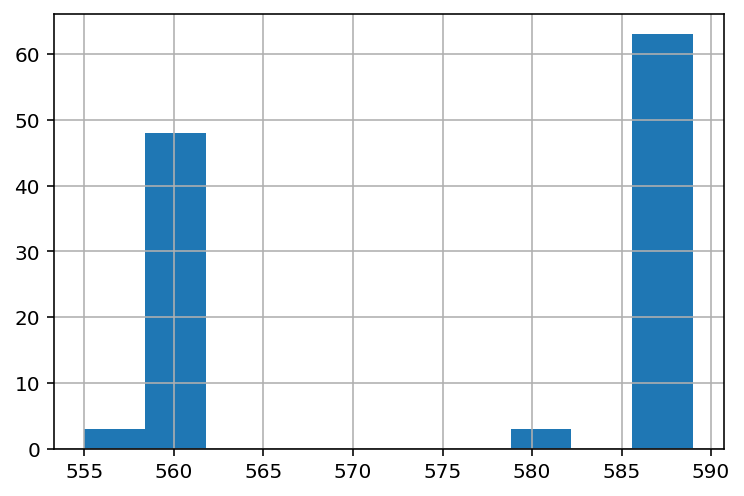

In [5]:
(UI_specimen_data_mt.meas_step_max-273).hist()

In [6]:
UI_1083_site_data_tc = UI_site_data_tc.iloc[0:3]
UI_1098_site_data_tc = UI_site_data_tc.iloc[3:5]

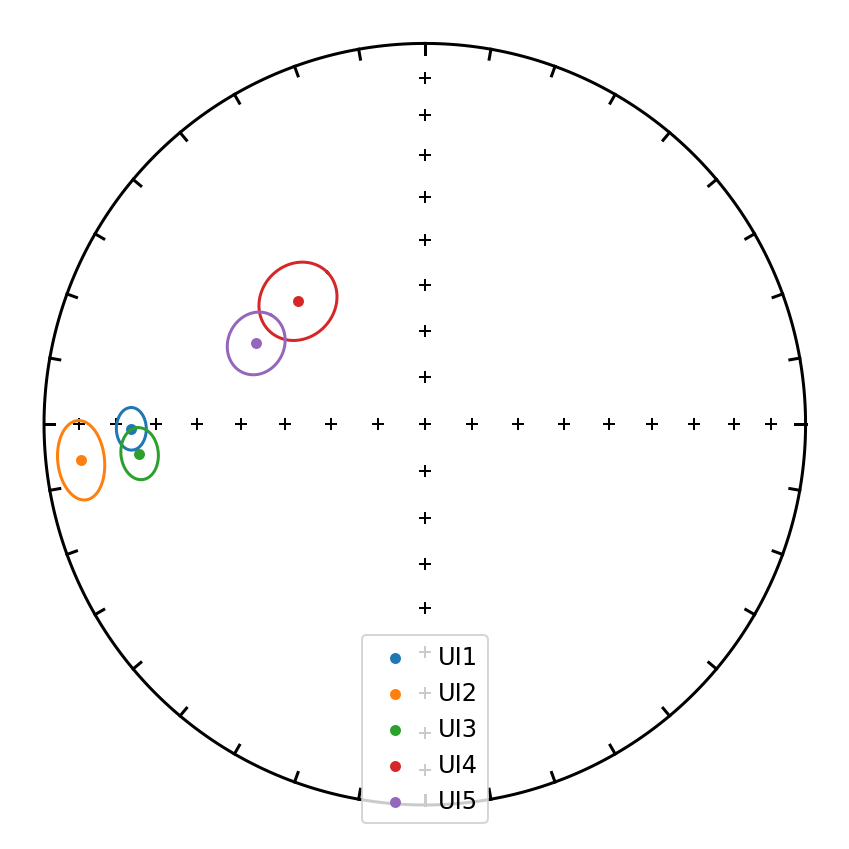

In [7]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(UI_site_data_tc.shape[0]):
    ipmag.plot_di_mean(UI_site_data_tc['dir_dec'].tolist()[i], 
                     UI_site_data_tc['dir_inc'].tolist()[i], 
                     UI_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'C'+str(i), label = UI_site_data_tc['site'].tolist()[i])
plt.legend(loc=8, fontsize=12)
plt.show()

### Unkar mean poles

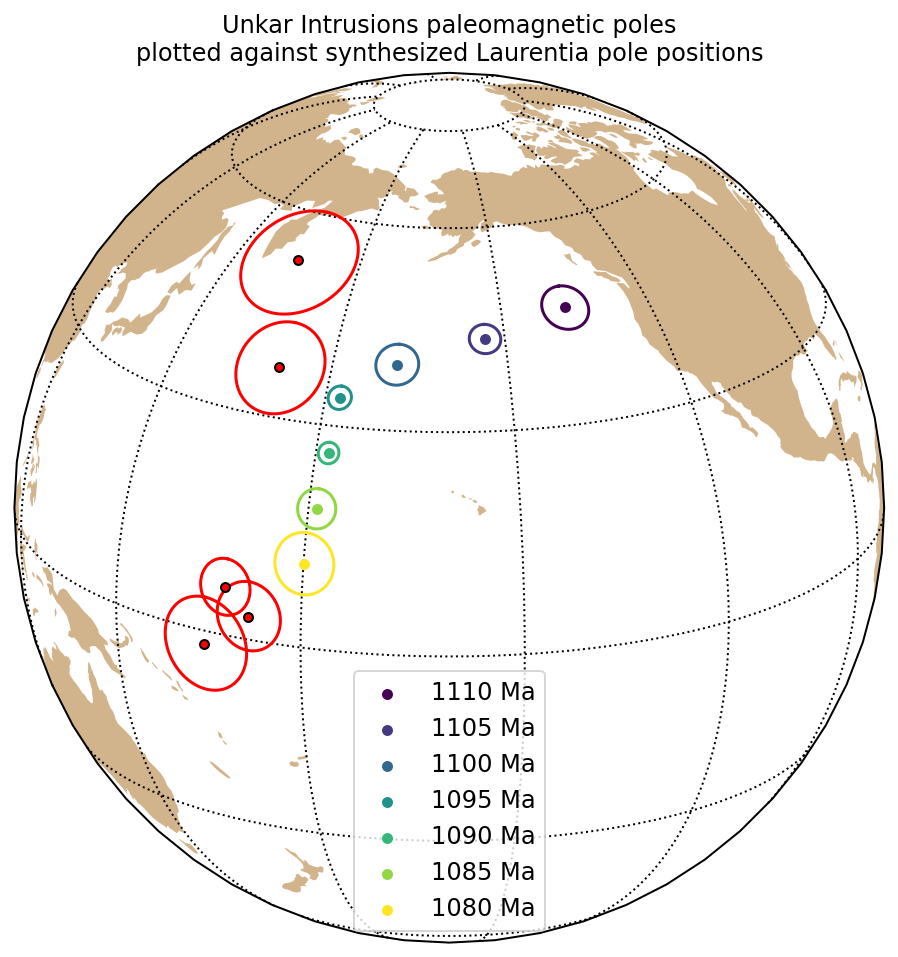

In [8]:
m = plot_APWP()
   
ipmag.plot_poles(m, UI_site_data_tc['vgp_lon'].tolist(), 
                     UI_site_data_tc['vgp_lat'].tolist(), 
                     UI_site_data_tc['dir_alpha95'].tolist(),
                     color = 'r')
plt.title('Unkar Intrusions paleomagnetic poles\nplotted against synthesized Laurentia pole positions')
plt.legend(loc=8, fontsize=12)
# plt.savefig('code_output/Unkar_Poles.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Unkar mean poles with Colorado Rotation

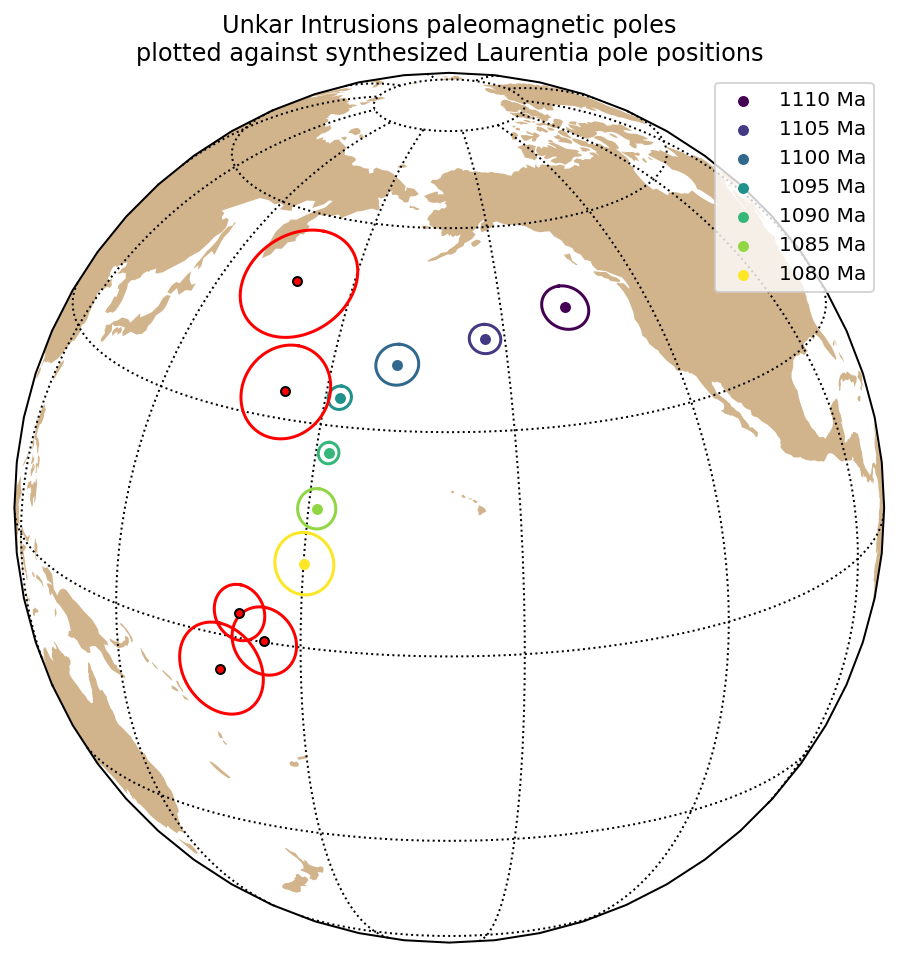

In [9]:
m = plot_APWP()

for i in range(UI_site_data_tc.shape[0]):
    this_lat, this_lon = pmag.pt_rot([37, -103, 3.9], [UI_site_data_tc['vgp_lat'].tolist()[i]], [UI_site_data_tc['vgp_lon'].tolist()[i]])
    
    ipmag.plot_pole(m, this_lon[0], 
                     this_lat[0], 
                     UI_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'r')
plt.title('Unkar Intrusions paleomagnetic poles\nplotted against synthesized Laurentia pole positions')
plt.legend()
# plt.savefig('code_output/Unkar_Poles.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Cardenas Basalt data

In [10]:
CB_site_data = all_sites_data[all_sites_data['site'].str.contains('CB')].reset_index(drop=1)
# get low temp component in geographic coordinates
CB_site_data_lt_gc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 0) & (CB_site_data['dir_comp_name'] == 'lt')]

# get mid temp component in tilt-corrected coordinates
CB_site_data_mt_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'mt')]

# get mid temp component in geographic coordinates for performing a Cardenas tilt test
CB_site_data_mt_gc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 0) & (CB_site_data['dir_comp_name'] == 'mt')]

# get maghemite temp component in tilt-corrected coordinates
CB_site_data_mht_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'mht')]

# get high temp component in tilt-corrected coordinates
CB_site_data_ht_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'ht')]

CB_specimen_data = all_specimens_data[all_specimens_data['site'].str.contains('CB')].reset_index(drop=1)
CB_specimen_data_lt_gc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 0) & (CB_specimen_data['dir_comp'] == 'lt')]
CB_specimen_data_mt_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'mt')]
CB_specimen_data_mht_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'mht')]
CB_specimen_data_ht_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'ht')]

#### calculate how many unique specimens had interpretable paleomagnetic results

In [11]:
len(CB_specimen_data.specimen.unique())

145

In [12]:
max((CB_specimen_data_lt_gc.meas_step_max-273))

300.0

#### Cardenas Basalt low temperature present day local field directions

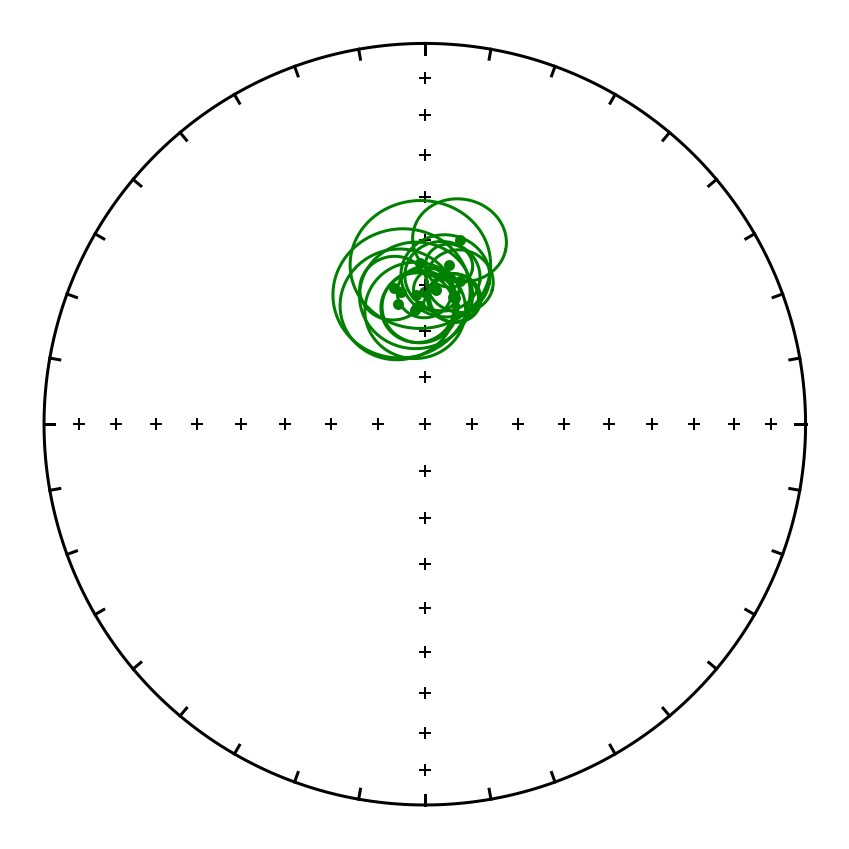

In [13]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_site_data_lt_gc.shape[0]):
    ipmag.plot_di_mean(CB_site_data_lt_gc['dir_dec'].tolist()[i], 
                     CB_site_data_lt_gc['dir_inc'].tolist()[i], 
                     CB_site_data_lt_gc['dir_alpha95'].tolist()[i],
                     color = 'green')
# plt.legend()
plt.show()

#### Cardenas Basalt medium temperature directions (tilt-corrected)

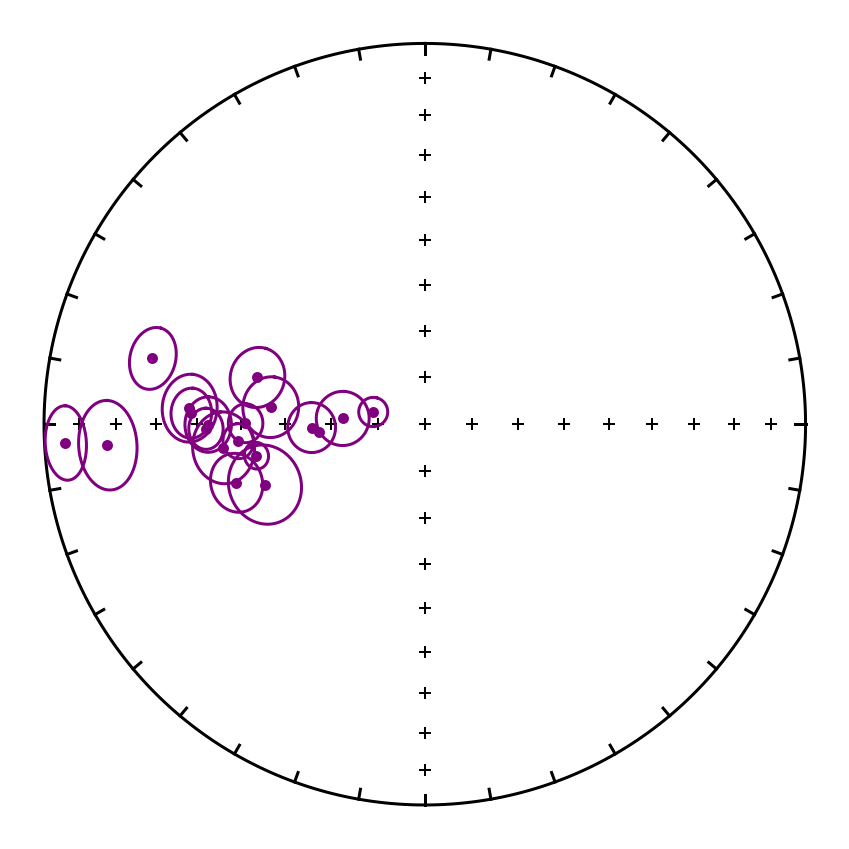

In [14]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_site_data_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_site_data_mt_tc['dir_dec'].tolist()[i], 
                     CB_site_data_mt_tc['dir_inc'].tolist()[i], 
                     CB_site_data_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')
# plt.legend()
plt.show()

#### Cardenas Basalt medium temperature direction tilt test

All Cardenas lavas are tilted in similar way such that the tilt-corrected site mean directions have slightly larger a95 than before tilt-correction. 

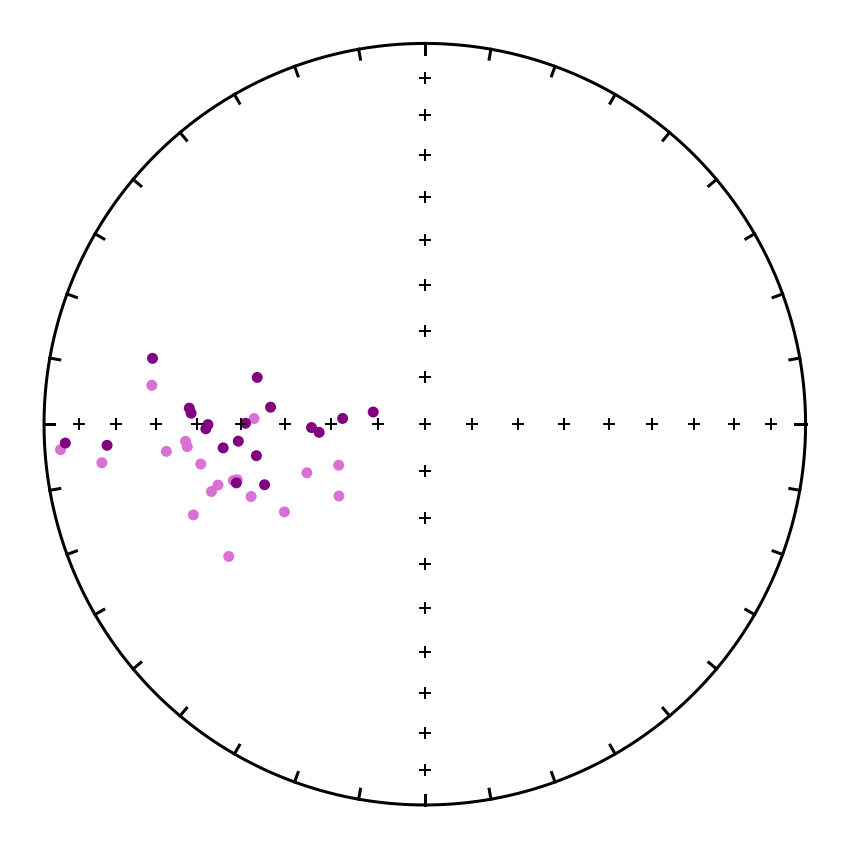

In [15]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(CB_site_data_mt_gc['dir_dec'].tolist(), 
                     CB_site_data_mt_gc['dir_inc'].tolist(),
                     color = 'orchid')
ipmag.plot_di(CB_site_data_mt_tc['dir_dec'].tolist(), 
                     CB_site_data_mt_tc['dir_inc'].tolist(),
                     color = 'purple')                    
# plt.legend()
plt.show()

In [16]:
ipmag.fisher_mean(CB_site_data_mt_gc['dir_dec'].tolist(), 
                     CB_site_data_mt_gc['dir_inc'].tolist())

{'dec': 256.4815248363649,
 'inc': 42.82047998891312,
 'n': 19,
 'r': 18.098858853744098,
 'k': 19.974673307047542,
 'alpha95': 7.699649336681444,
 'csd': 18.123629542955143}

In [17]:
ipmag.fisher_mean(CB_site_data_mt_tc['dir_dec'].tolist(), 
                     CB_site_data_mt_tc['dir_inc'].tolist())

{'dec': 268.82404440582144,
 'inc': 48.04482531522362,
 'n': 19,
 'r': 18.04563665283171,
 'k': 18.860741093429624,
 'alpha95': 7.935810063825905,
 'csd': 18.65115117205481}

### Cardenas Basalt at Nankoweap trail

site CB1, CB2, CB3, CB4, CB5, CB6, CB7 are collected form river mile 52 Nankoweap Trail. 


2 specimens from CB4 has decent mt component; other specimens typically have a mht component that has the opposite direction as the ht component which gets up to 680 degre unblocking temperature. This is likely a signal of having self-reversal magnetization as maghematization alters primary magnetite into maghemite. 

#### CB1

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [18]:
CB1_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB1']
CB1_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB1']
CB1_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB1']

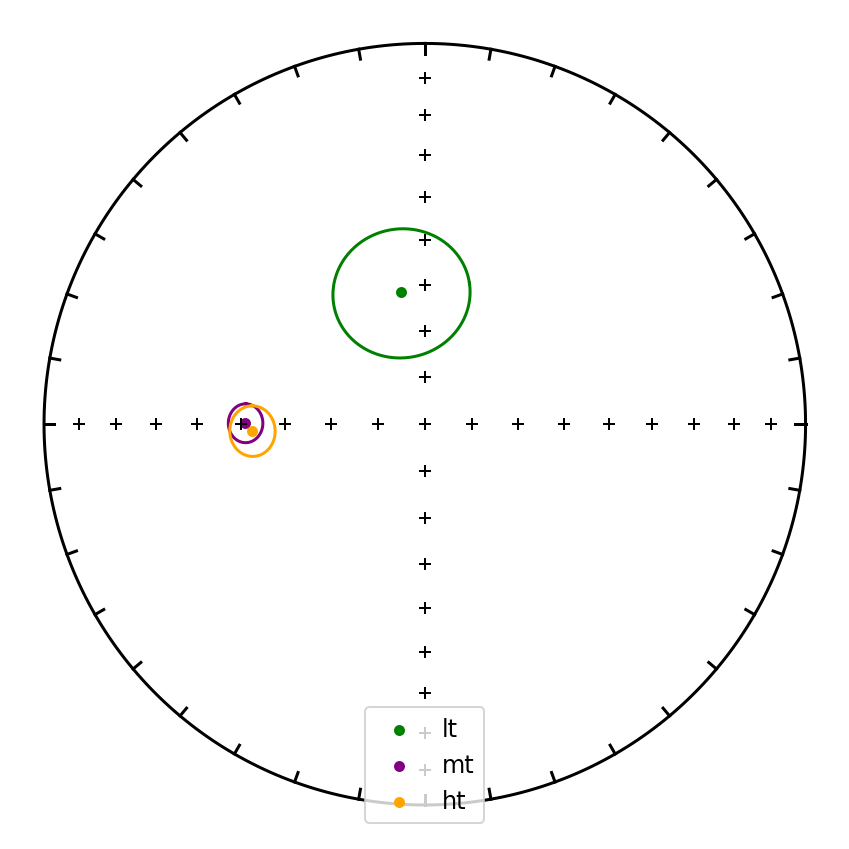

In [19]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB1_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB1_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB1_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB1_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB1_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB1_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB1_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB1_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB1_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB2

This flow has minimal pdf field direction and a quite steep magnetite mt component

**one note regarding this site is that this is interpreted to be from the same flow as CB3 based on field observations (both are from a 56.8m flow but yet CB2 directions are so steep and distinct from that of CB3. 

In [20]:
CB2_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB2']

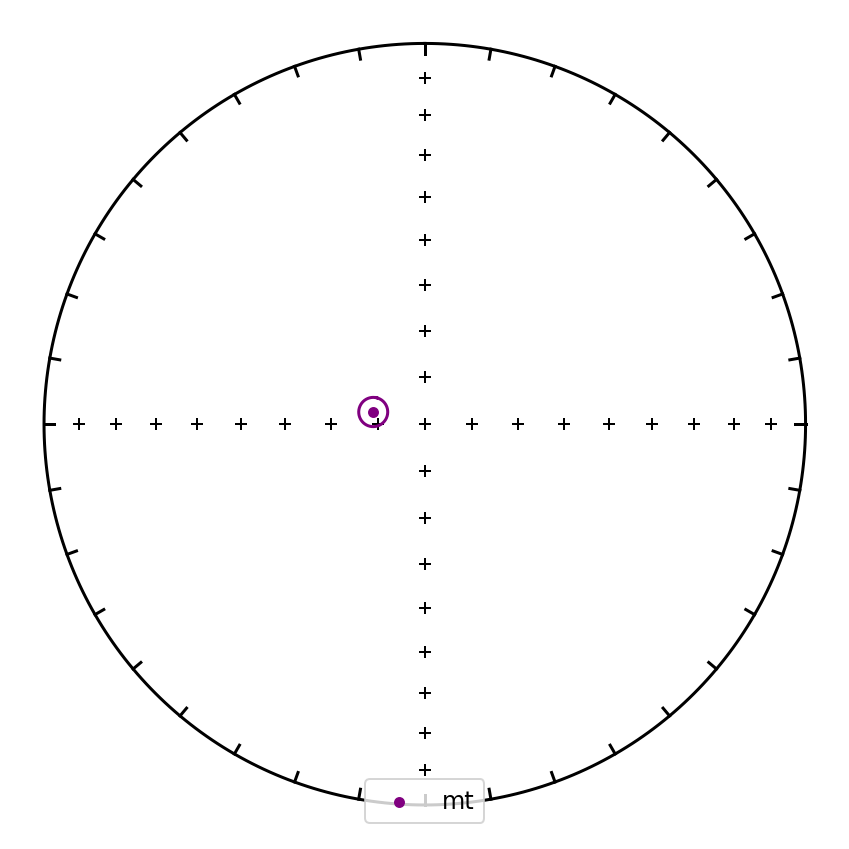

In [21]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB2_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB2_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB2_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB3

This flow has a pdf field direction and a magnetite mt component and an ht component that overlaps with mt

In [22]:
CB3_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB3']
CB3_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB3']
CB3_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB3']

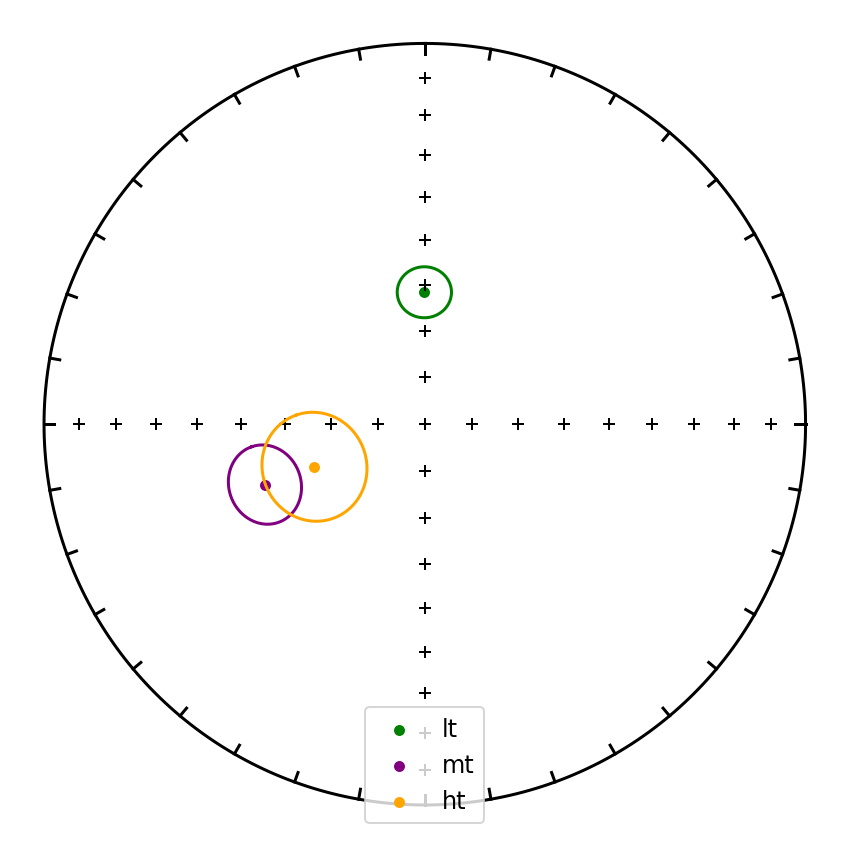

In [23]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB3_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB3_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB3_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB3_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB3_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB3_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB3_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB3_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB3_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB4

This flow is a special one. It is in general fine-grained, vesicular basalt that appears red in color. It has a complex combination of four components including a lt pdf component, a mt magnetite direction in a couple of samples that record the expected direction at ca. 1083 Ma, and a dominant mht component that always has an antipodal direction as the mt and ht, and a high temperature ht component that record directions similar to mt component.

Specimen 2a is collected 20 cm above the base of the flow. This specimen is the only one that does not have an antipode direction. Its mt component unblock up to ca. 580 C when it was almost completely demagnetized. 

In all other specimens, the mht component typically unblocks between 350-600 C and have antipodal directions to their ht component directions.

**CB4 specimen mht and ht directions pass common mean test with classification of 'C'**

**CB4 specimen mht and ht+mt directions pass common mean test with classification of 'C'**

**we combine the mt direction from specimen 2a and the ht directions from other specimens to calculate a mean for this site**

In [24]:
CB4_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB4']
CB4_site_data_mht_tc = CB_site_data_mht_tc
CB4_site_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB4']

CB4_specimen_ht_tc = CB_specimen_data_ht_tc[CB_specimen_data_ht_tc['site'] == 'CB4']
CB4_specimen_mht_tc = CB_specimen_data_mht_tc[CB_specimen_data_mht_tc['site'] == 'CB4']
CB4_specimen_mt_tc = CB_specimen_data_mt_tc[CB_specimen_data_mt_tc['site'] == 'CB4']

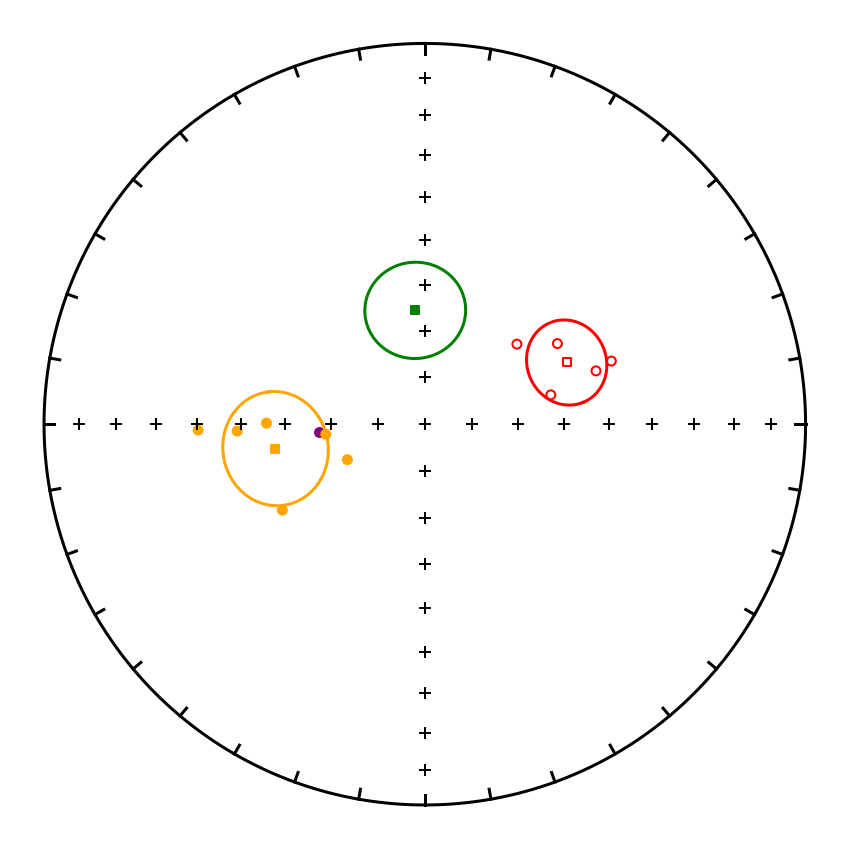

In [25]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(CB4_specimen_mt_tc['dir_dec'].tolist(), 
              CB4_specimen_mt_tc['dir_inc'].tolist(), 
              color = 'purple')
ipmag.plot_di(CB4_specimen_mht_tc['dir_dec'].tolist(), 
              CB4_specimen_mht_tc['dir_inc'].tolist(), 
              color = 'red')
ipmag.plot_di(CB4_specimen_ht_tc['dir_dec'].tolist(), 
              CB4_specimen_ht_tc['dir_inc'].tolist(), 
              color = 'orange')


ipmag.plot_di_mean(CB4_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB4_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB4_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   marker = 's', color='green', label='lt')

ipmag.plot_di_mean(CB4_site_data_mht_tc['dir_dec'].tolist()[0],  
                   CB4_site_data_mht_tc['dir_inc'].tolist()[0], 
                   CB4_site_data_mht_tc['dir_alpha95'].tolist()[0], 
                   marker = 's', color='red', label='mht')

ipmag.plot_di_mean(CB4_site_ht_tc['dir_dec'].tolist()[0],  
                   CB4_site_ht_tc['dir_inc'].tolist()[0], 
                   CB4_site_ht_tc['dir_alpha95'].tolist()[0], 
                   marker = 's', color='orange')

In [26]:
ipmag.reversal_test_MM1990(dec=CB4_specimen_ht_tc['dir_dec'].tolist()+CB4_specimen_mht_tc['dir_dec'].tolist(), 
                           inc=CB4_specimen_ht_tc['dir_inc'].tolist()+CB4_specimen_mht_tc['dir_inc'].tolist())

Results of Watson V test: 

Watson's V:           2.4
Critical value of V:  7.2
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 7.8
Critical angle for M&M1990:   13.5
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 7.780376177760243, 13.524740968093642, 'C')

In [27]:
ipmag.reversal_test_MM1990(dec=CB4_specimen_ht_tc['dir_dec'].tolist()+CB4_specimen_mht_tc['dir_dec'].tolist()+CB4_specimen_mt_tc['dir_dec'].tolist(), 
                           inc=CB4_specimen_ht_tc['dir_inc'].tolist()+CB4_specimen_mht_tc['dir_inc'].tolist()+CB4_specimen_mt_tc['dir_inc'].tolist())

Results of Watson V test: 

Watson's V:           3.1
Critical value of V:  7.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 8.2
Critical angle for M&M1990:   12.3
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 8.167620593619487, 12.291965623417386, 'C')

In [28]:
CB4_directions = pd.concat([CB4_specimen_ht_tc, CB4_specimen_mt_tc])
CB4_directions.head()

specimen      experiments sample  dir_alpha95 dir_comp  dir_dec  dir_inc  \
643   CB4-3a  CB4-3a_LP-DIR-T  CB4-3          NaN       ht    238.9     54.0   
662   CB4-4a  CB4-4a_LP-DIR-T  CB4-4          NaN       ht    264.2     68.7   
667   CB4-5a  CB4-5a_LP-DIR-T  CB4-5          NaN       ht    267.9     49.2   
675   CB4-6a  CB4-6a_LP-DIR-T  CB4-6          NaN       ht    270.4     55.8   
691   CB4-7a  CB4-7a_LP-DIR-T  CB4-7          NaN       ht    268.5     40.2   

     dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  int_corr  \
643          3.0                 8.0                100.0  ...         u   
662          3.0                25.0                100.0  ...         u   
667          3.0                11.0                100.0  ...         u   
675          3.0                 9.0                100.0  ...         u   
691          3.0                12.0                100.0  ...         u   

      citations                   method_codes  result_quality volume  weight  \
643  This study    LP-DIR-T:DE-BFL:DA-DIR-TILT               g    NaN     NaN   
662  This study  LP-DIR-T:DE-BFL-A:DA-DIR-TILT               g    NaN     NaN   
667  This study  LP-DIR-T:DE-BFL-A:DA-DIR-TILT               g    NaN     NaN   
675  This study    LP-DIR-T:DE-BFL:DA-DIR-TILT               g    NaN     NaN   
691  This study    LP-DIR-T:DE-BFL:DA-DIR-TILT               g    NaN     NaN   

         location site        lat         lon  
643  Grand Canyon  CB4  36.283056 -111.892778  
662  Grand Canyon  CB4  36.283056 -111.892778  
667  Grand Canyon  CB4  36.283056 -111.892778  
675  Grand Canyon  CB4  36.283056 -111.892778  
691  Grand Canyon  CB4  36.283056 -111.892778  

[5 rows x 28 columns]

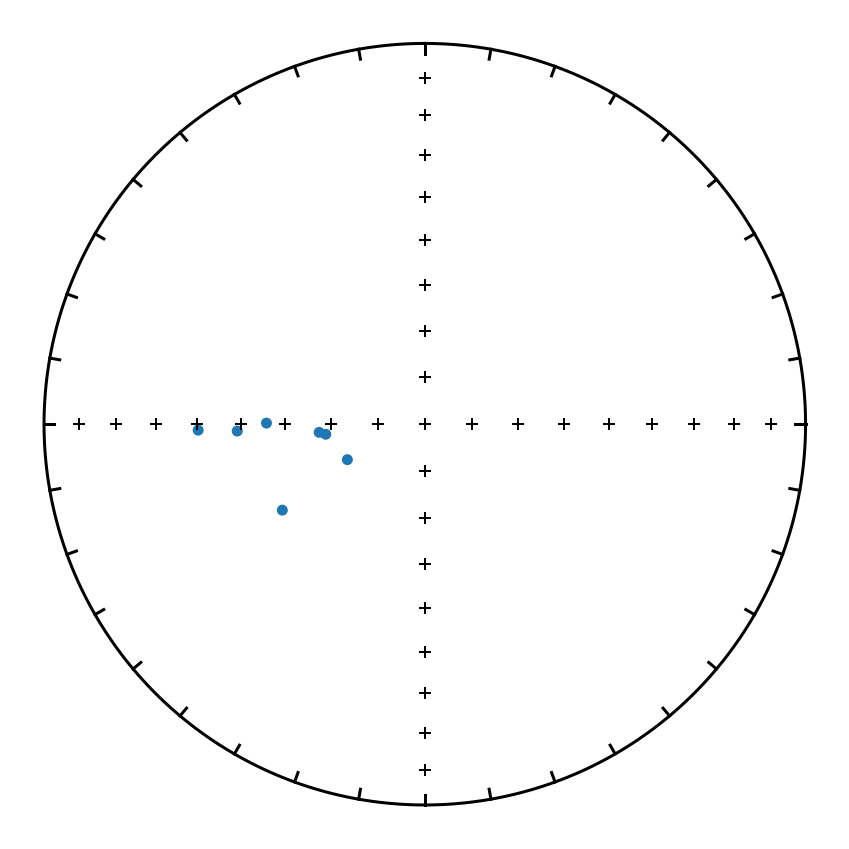

In [29]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(CB4_directions['dir_dec'].tolist(), 
                     CB4_directions['dir_inc'].tolist(),
                     color = 'C0')
plt.show()

**recalculate CB4 mean direction using combined mt, mht, ht components**

In [30]:
CB4_mean_dir = ipmag.fisher_mean(CB4_directions['dir_dec'].tolist(), CB4_directions['dir_inc'].tolist())
CB4_mean_dir

{'dec': 261.25948616158814,
 'inc': 58.693912646228306,
 'n': 7,
 'r': 6.838397544216533,
 'k': 37.12814864669793,
 'alpha95': 10.036357588532361,
 'csd': 13.293317321091129}

**recalculate CB4 mean pole using combined mt, mht, ht components**

In [31]:
CB4_vgps = np.array([pmag.dia_vgp(CB4_directions['dir_dec'].tolist()[i], 
                                  CB4_directions['dir_inc'].tolist()[i], 
                                  0, 
                                  CB4_site_data_mht_tc['lat'].tolist()[0], 
                                  CB4_site_data_mht_tc['lon'].tolist()[0]) for i in range(CB4_directions.shape[0])]).T[:2]
CB4_dpdm = pmag.dia_vgp(CB4_mean_dir['dec'], 
                        CB4_mean_dir['inc'], 
                        CB4_mean_dir['alpha95'], 
                        CB4_site_data_mht_tc['lat'].tolist()[0], 
                        CB4_site_data_mht_tc['lon'].tolist()[0])
CB4_mean_pole = ipmag.fisher_mean(CB4_vgps[0], CB4_vgps[1])

#### CB5

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [32]:
CB5_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB5']
CB5_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB5']
CB5_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB5']

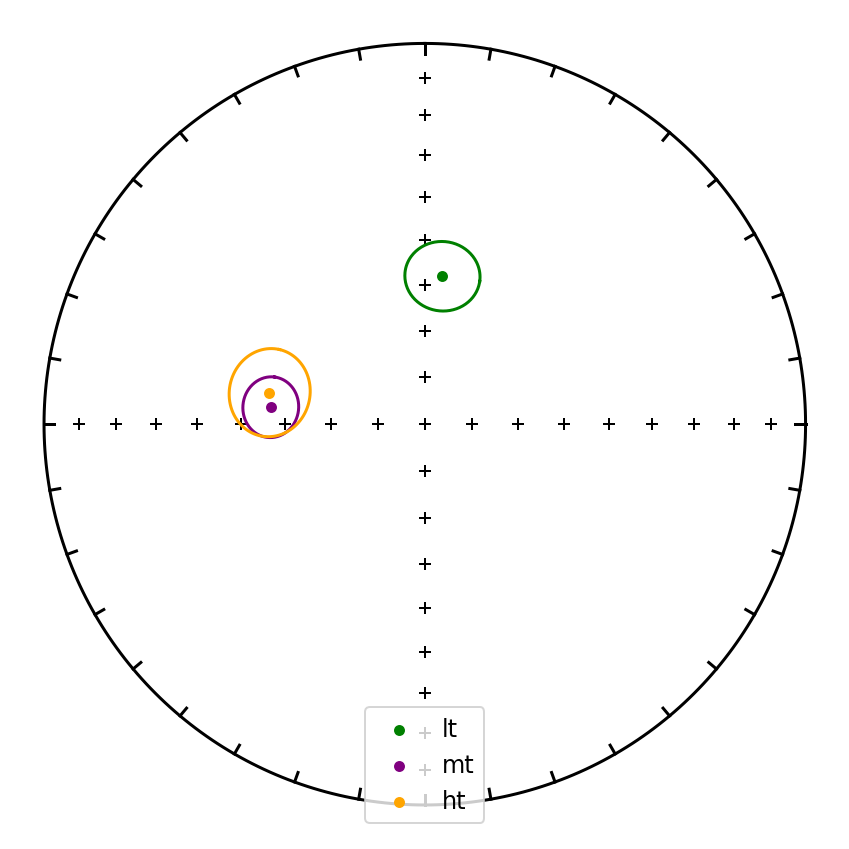

In [33]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB5_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB5_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB5_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB5_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB5_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB5_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB5_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB5_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB5_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### Nankoweap summary

combining CB1-CB5 site data with updated CB4 directions (combining ht and mt directions)

In [34]:
CB_Nankoweap_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'].isin(['CB1','CB2','CB3','CB5'])]

In [35]:
CB_Nankoweap_tc = CB_Nankoweap_tc.append({ 'site': 'CB4',
                            'location':                                                       'Grand Canyon',
                            'samples':                    'CB4-2:CB4-3:CB4-4:CB4-5:CB4-6:CB4-7:CB4-8',
                            'specimens':           'CB4-2a:CB4-3a:CB4-4a:CB4-5a:CB4-6a:CB4-7a:CB4-8a',
                            'dir_alpha95':                                   round(CB4_mean_dir['alpha95'],1),
                            'dir_comp_name':                                                            'mt',
                            'dir_dec':                                                              round(CB4_mean_dir['dec'],1),
                            'dir_inc':                                                              round(CB4_mean_dir['inc'],1),
                            'dir_k':                                                                round(CB4_mean_dir['k'],1),
                            'dir_n_samples':                                                        8,
                            'dir_n_specimens':                                                      8,
                            'dir_n_specimens_lines':                                                8,
                            'dir_n_specimens_planes':                                               0,
                            'dir_polarity':                                                              't',
                            'dir_r':                                                                round(CB4_mean_dir['r'],1),
                            'dir_tilt_correction':                                                     100,
                            'lat':                                                                   CB4_site_data_mht_tc['lat'].tolist()[0],
                            'lon':                                                                  CB4_site_data_mht_tc['lon'].tolist()[0],
                            'analysts':                                                                'NaN',
                            'criteria':                                                             'ACCEPT',
                            'software_packages':                          'pmagpy-4.2.24-1: demag_gui.v.3.0',
                            'citations':                                                        'This study',
                            'method_codes':              'LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO',
                            'result_quality':                                                            'g',
                            'vgp_dm':                                                                  CB4_dpdm[2],
                            'vgp_dp':                                                                  CB4_dpdm[3],
                            'vgp_lat':                                                                CB4_mean_pole['inc'],
                            'vgp_lon':                                                               CB4_mean_pole['dec']}, ignore_index=1)


In [36]:
CB_Nankoweap_tc

site      location                                            samples  \
0  CB1  Grand Canyon    CB1-1:CB1-2:CB1-3:CB1-4:CB1-5:CB1-6:CB1-7:CB1-8   
1  CB2  Grand Canyon    CB2-1:CB2-2:CB2-3:CB2-4:CB2-5:CB2-6:CB2-7:CB2-8   
2  CB3  Grand Canyon          CB3-1:CB3-2:CB3-3:CB3-4:CB3-6:CB3-7:CB3-8   
3  CB5  Grand Canyon  CB5-1:CB5-2:CB5-3:CB5-4:CB5-5:CB5-6:CB5-7:CB5-...   
4  CB4  Grand Canyon          CB4-2:CB4-3:CB4-4:CB4-5:CB4-6:CB4-7:CB4-8   

                                           specimens  dir_alpha95  \
0  CB1-1a:CB1-2a:CB1-3a:CB1-4a:CB1-5a:CB1-6a:CB1-...          3.9   
1  CB2-1a:CB2-2a:CB2-3a:CB2-4a:CB2-5a:CB2-6a:CB2-...          3.1   
2   CB3-1a:CB3-2a:CB3-3a:CB3-4a:CB3-6a:CB3-7a:CB3-8a          8.1   
3  CB5-1a:CB5-2a:CB5-3a:CB5-4a:CB5-5a:CB5-6a:CB5-...          6.2   
4   CB4-2a:CB4-3a:CB4-4a:CB4-5a:CB4-6a:CB4-7a:CB4-8a         10.0   

  dir_comp_name  dir_dec  dir_inc  dir_k  dir_n_samples  ...  analysts  \
0            mt    270.3     51.1  200.0              8  ...       NaN   
1            mt    283.3     78.7  329.0              8  ...       NaN   
2            mt    249.3     52.9   56.0              7  ...       NaN   
3            mt    276.3     56.5   71.0              9  ...       NaN   
4            mt    261.3     58.7   37.1              8  ...       NaN   

   criteria                 software_packages   citations  \
0    ACCEPT  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
1    ACCEPT  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
2    ACCEPT  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
3    ACCEPT  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
4    ACCEPT  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   

                                        method_codes  result_quality  vgp_dm  \
0  LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...               g    5.30   
1  LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...               g    5.90   
2  LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...               g   11.20   
3  LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...               g    9.00   
4  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   11.09   

   vgp_dp    vgp_lat     vgp_lon  
0    3.60  18.400000  184.500000  
1    5.60  38.200000  220.800000  
2    7.70   5.100000  196.500000  
3    6.50  25.300000  186.800000  
4   14.92  16.915483  196.937895  

[5 rows x 28 columns]

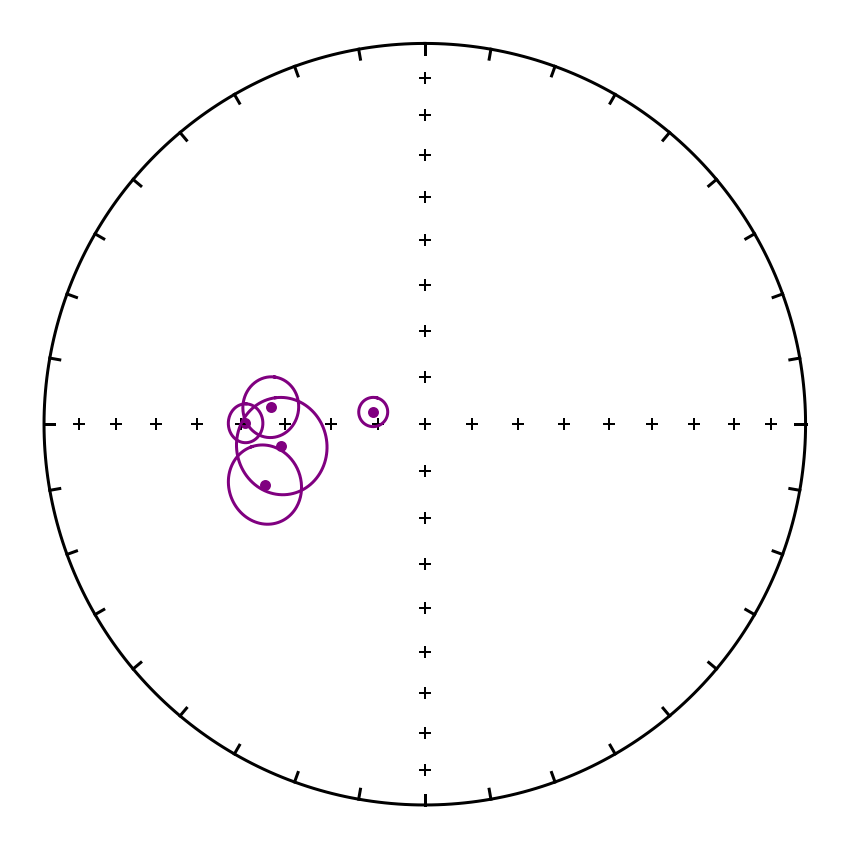

In [37]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Nankoweap_tc.shape[0]):
    ipmag.plot_di_mean(CB_Nankoweap_tc['dir_dec'].tolist()[i], 
                     CB_Nankoweap_tc['dir_inc'].tolist()[i], 
                     CB_Nankoweap_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

# plt.legend()
plt.show()

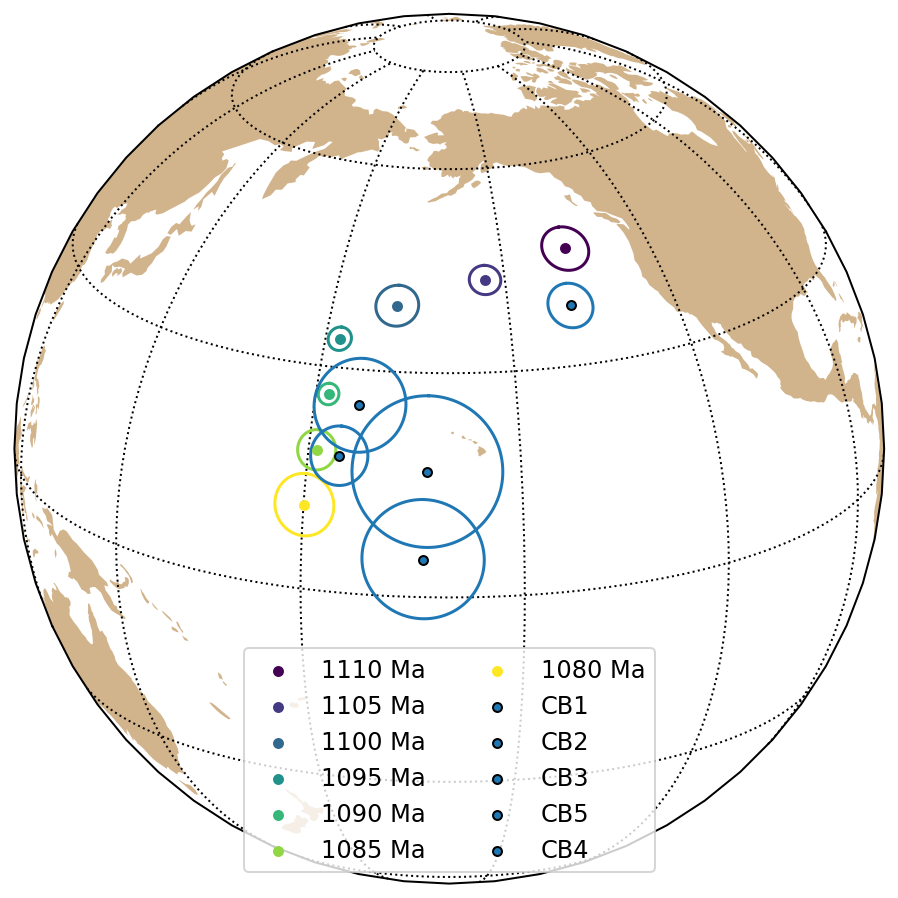

In [38]:
m = plot_APWP()

for i in range(CB_Nankoweap_tc.shape[0]):
    ipmag.plot_pole(m, CB_Nankoweap_tc['vgp_lon'].tolist()[i], 
                     CB_Nankoweap_tc['vgp_lat'].tolist()[i], 
                     CB_Nankoweap_tc['dir_alpha95'].tolist()[i],
                     color = 'C0', label = CB_Nankoweap_tc['site'].tolist()[i])


plt.legend(loc=8, ncol=2, fontsize=12)
plt.show()

In [39]:
bool(['1'])

True

### Cardenas Basalt at Lava Chuar Canyon

site CB6, CB7 are collected form river mile 65 Lava Chuar

#### CB6

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [40]:
CB6_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB6']
CB6_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB6']
CB6_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB6']

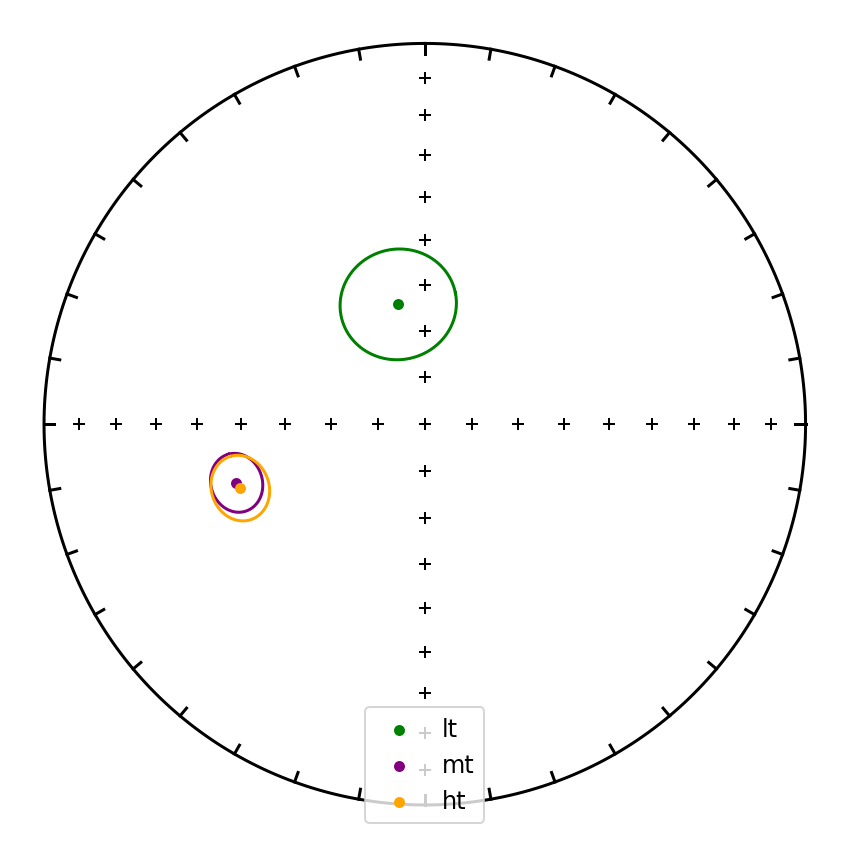

In [41]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB6_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB6_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB6_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB6_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB6_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB6_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB6_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB6_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB6_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB7

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [42]:
CB7_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB7']
CB7_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB7']
CB7_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB7']

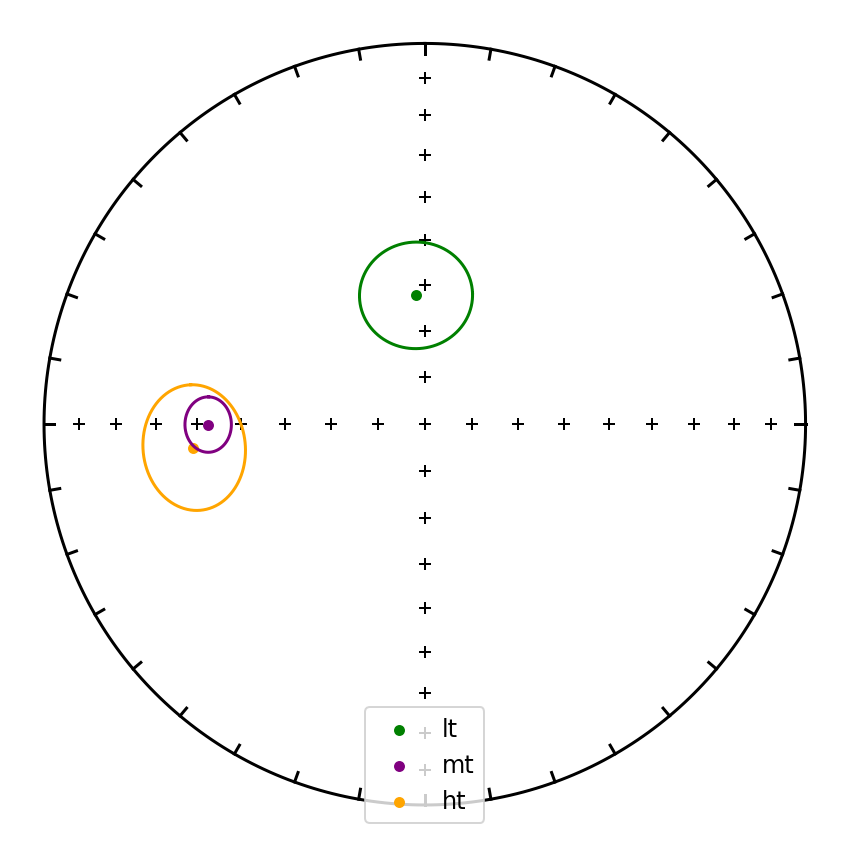

In [43]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB7_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB7_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB7_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB7_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB7_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB7_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB7_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB7_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB7_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### Lava Chuar summary

combining CB6-CB7 site data

In [44]:
CB_Lava_Chuar_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'].isin(['CB6','CB7'])]

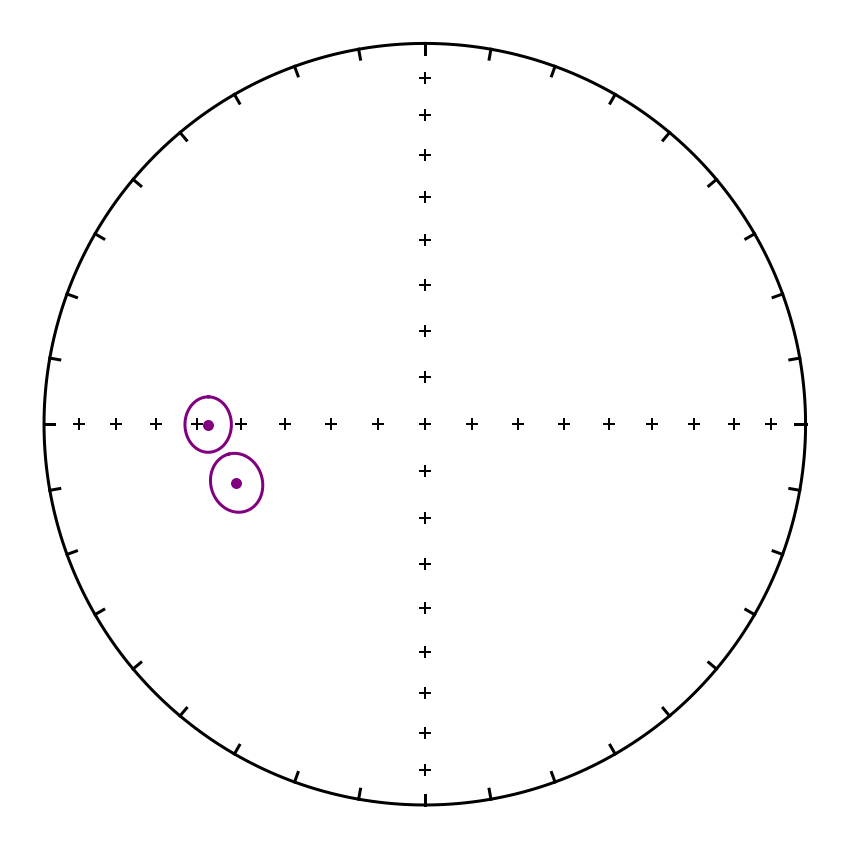

In [45]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Lava_Chuar_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_Lava_Chuar_mt_tc['dir_dec'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_inc'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

# plt.legend()
plt.show()

### Cardenas Basalt at Basalt Canyon

site CB8-18 and CBS1 are collected form river mile 70 Basalt Canyon. 

#### CB8

This flow has a lt pdf component and a mt component. It has a few ht directions in some specimens but if fitted, they sit along a swath from mt to lt component. The remanence could be more recently oxidized hematite that has pdf overprint. Thus we only show the mt and lt component here.

In [46]:
CB8_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB8']
CB8_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB8']

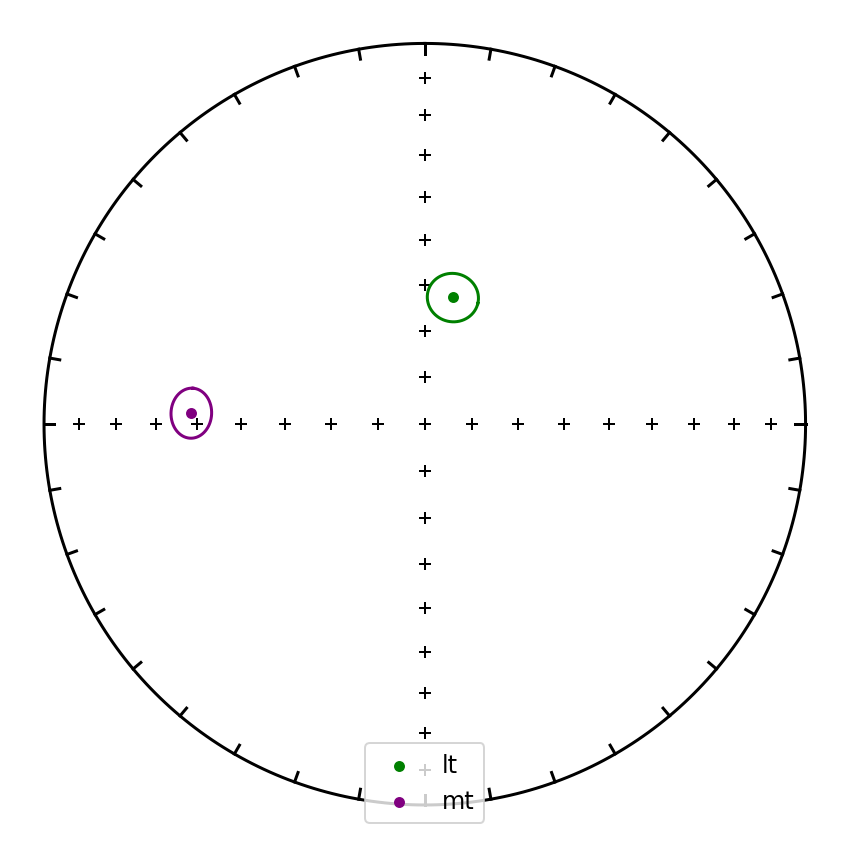

In [47]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB8_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB8_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB8_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB8_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB8_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB8_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB9

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [48]:
CB9_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB9']
CB9_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB9']
CB9_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB9']

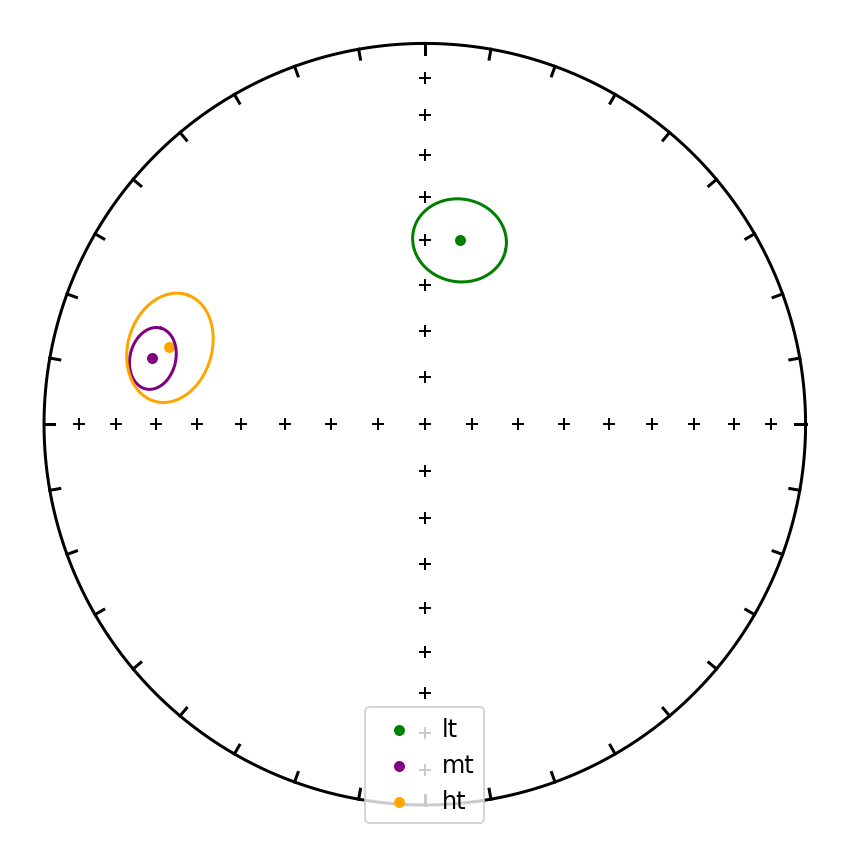

In [49]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB9_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB9_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB9_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB9_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB9_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB9_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB9_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB9_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB9_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB10

This flow has a lt pdf component and a characteristic mt component after removal of the lt component. It has minimal ht component.

In [50]:
CB10_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB10']
CB10_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB10']

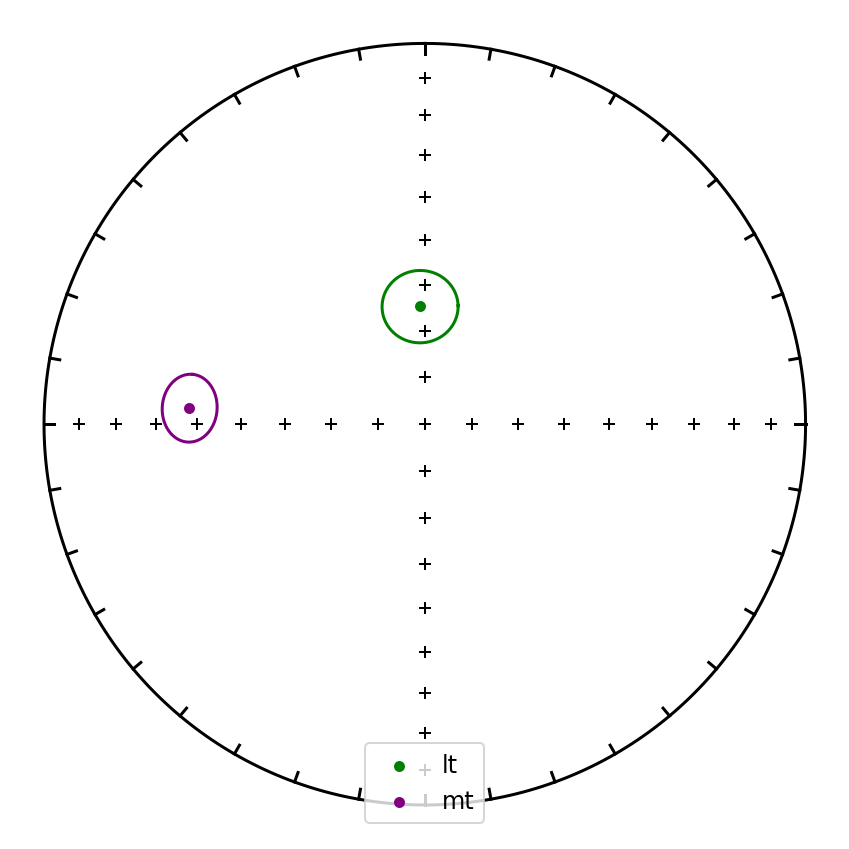

In [51]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB10_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB10_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB10_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB10_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB10_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB10_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CBS1

This unit is interbedded quartz sandstone between basalt flow CB10 and CB11. Based on the demag spectra there is a bend near magnetite Curie temperature and another hear hematite Neel temperature and hematite (likely baked) recorddominant remanence. The mt and ht directionsa re indistinguishable. 

In [52]:
CBS1_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CBS1']
CBS1_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CBS1']

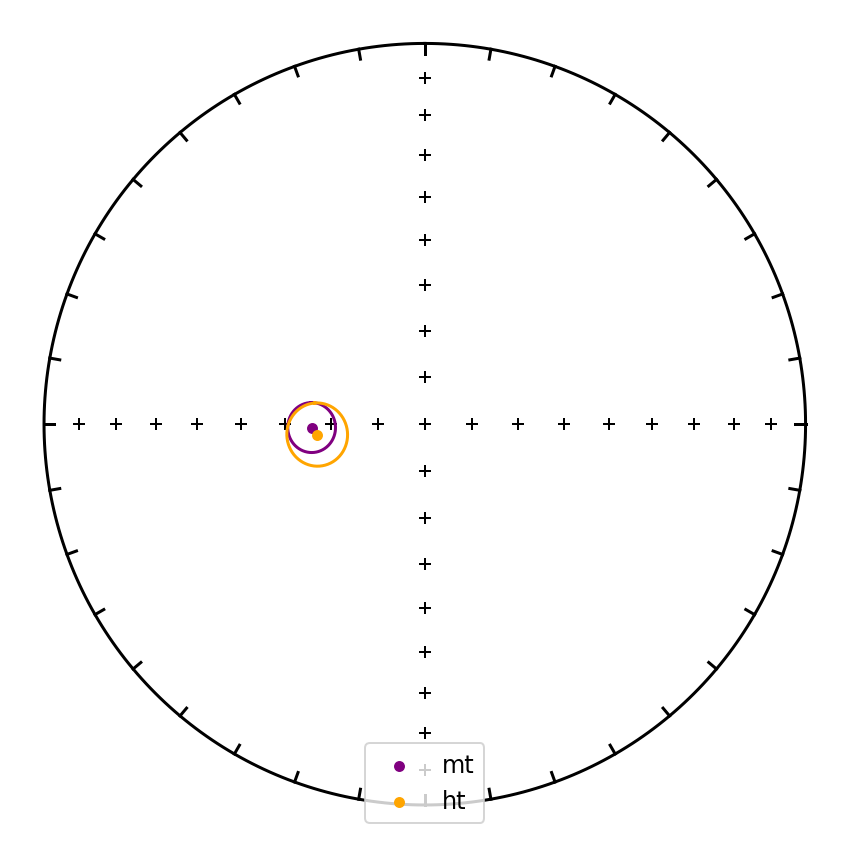

In [53]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CBS1_site_data_mt_tc.dir_dec.tolist()[0], 
                   CBS1_site_data_mt_tc.dir_inc.tolist()[0], 
                   CBS1_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CBS1_site_data_ht_tc.dir_dec.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_inc.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB11

This flow has a lt pdf component and a characteristic mt component after removal of the lt component. It has minimal ht component. The mt component has quite a steep inclination.

In [54]:
CB11_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB11']
CB11_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB11']

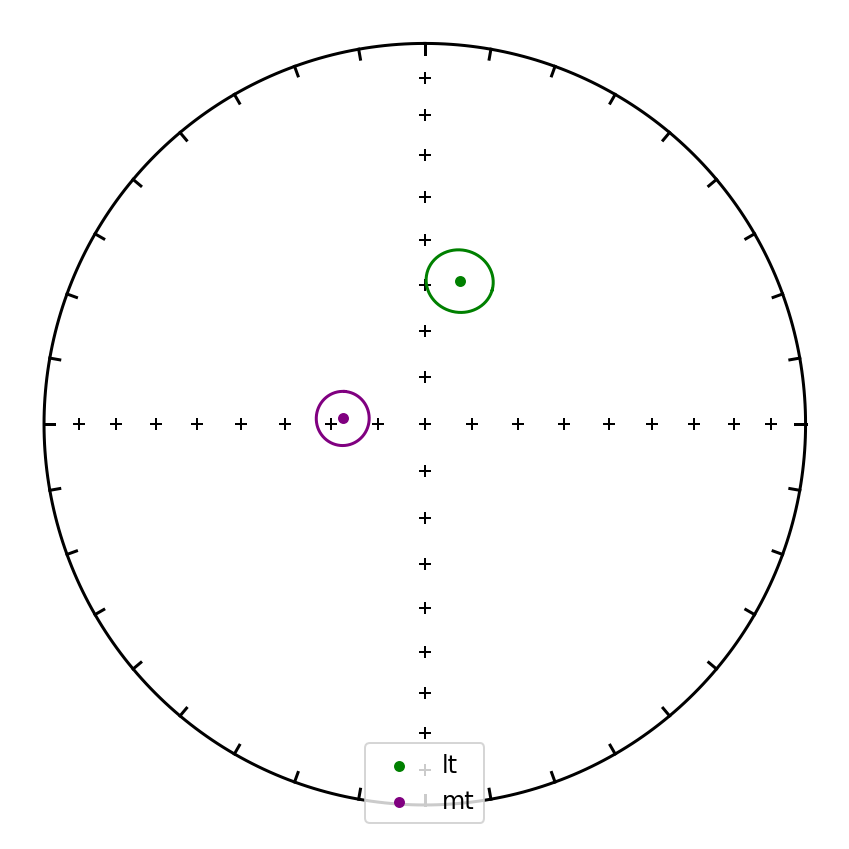

In [55]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB11_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB11_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB11_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB11_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB11_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB11_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### comparing directions of CBS1 and CB11

The specimen ht directions of CBS1 and CB11 pass a Watson common mean test with classification of B. This supports the interpretation that the thin 0.7 meter thick CBS bed was baked by flow CB11 on top of it when CB11 was emplaced. 

In [56]:
CBS1_specimen_data_ht_tc = CB_specimen_data_ht_tc[CB_specimen_data_ht_tc['site'] == 'CBS1']
CB11_specimen_data_mt_tc = CB_specimen_data_mt_tc[CB_specimen_data_mt_tc['site'] == 'CB11']

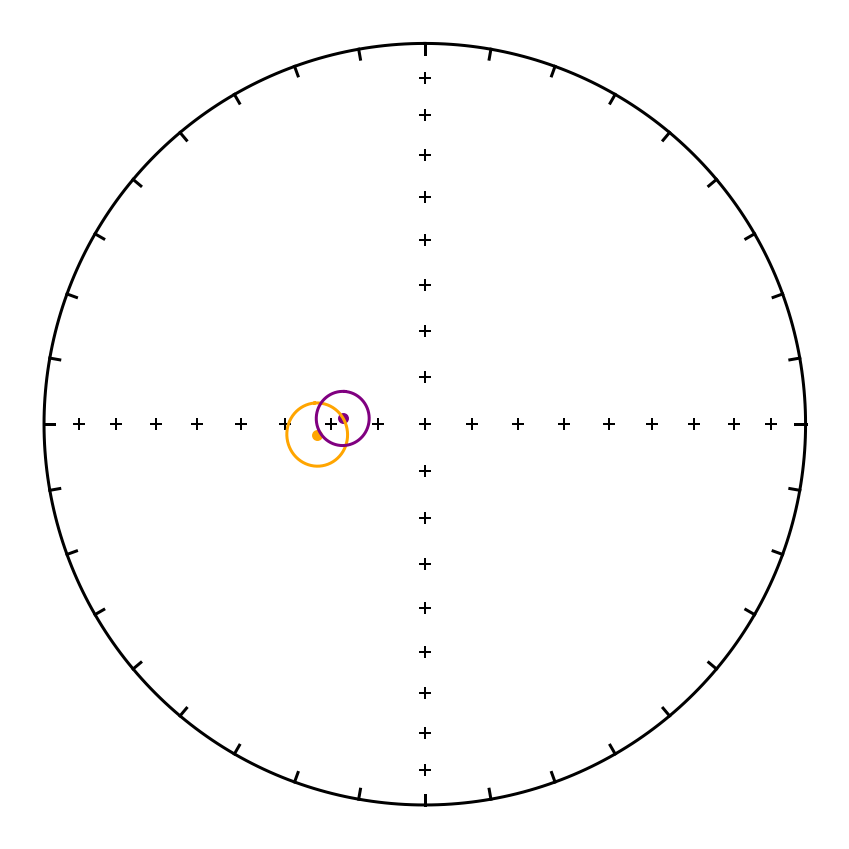

In [57]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CBS1_site_data_ht_tc.dir_dec.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_inc.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')
ipmag.plot_di_mean(CB11_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB11_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB11_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

In [58]:
ipmag.common_mean_watson(CBS1_specimen_data_ht_tc[['dir_dec','dir_inc']].to_numpy(), CB11_specimen_data_mt_tc[['dir_dec','dir_inc']].to_numpy())

Results of Watson V test: 

Watson's V:           4.4
Critical value of V:  7.3
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.5
Critical angle for M&M1990:   8.4
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 6.529879289492213, 8.41959920247678, 'B')

#### Let's combine CBS1 and CB specimen data and merge them into one site

In [59]:
CB11_CBS1 = pd.concat([CB11_specimen_data_mt_tc, CBS1_specimen_data_ht_tc])
CB11_CSB1_mean_dir = ipmag.fisher_mean(CB11_CBS1.dir_dec.tolist(), CB11_CBS1.dir_inc.tolist())
CB11_CSB1_vgps = np.array([pmag.dia_vgp(CB11_CBS1['dir_dec'].tolist()[i], 
                                  CB11_CBS1['dir_inc'].tolist()[i], 
                                  0, 
                                  CB11_CBS1['lat'].tolist()[0], 
                                  CB11_CBS1['lon'].tolist()[0]) for i in range(CB11_CBS1.shape[0])]).T[:2]
CB11_CSB1_dpdm = pmag.dia_vgp(CB11_CSB1_mean_dir['dec'], 
                        CB11_CSB1_mean_dir['inc'], 
                        CB11_CSB1_mean_dir['alpha95'], 
                        CB11_CBS1['lat'].tolist()[0], 
                        CB11_CBS1['lon'].tolist()[0])
CB11_CSB1_mean_pole = ipmag.fisher_mean(CB11_CSB1_vgps[0], CB11_CSB1_vgps[1])

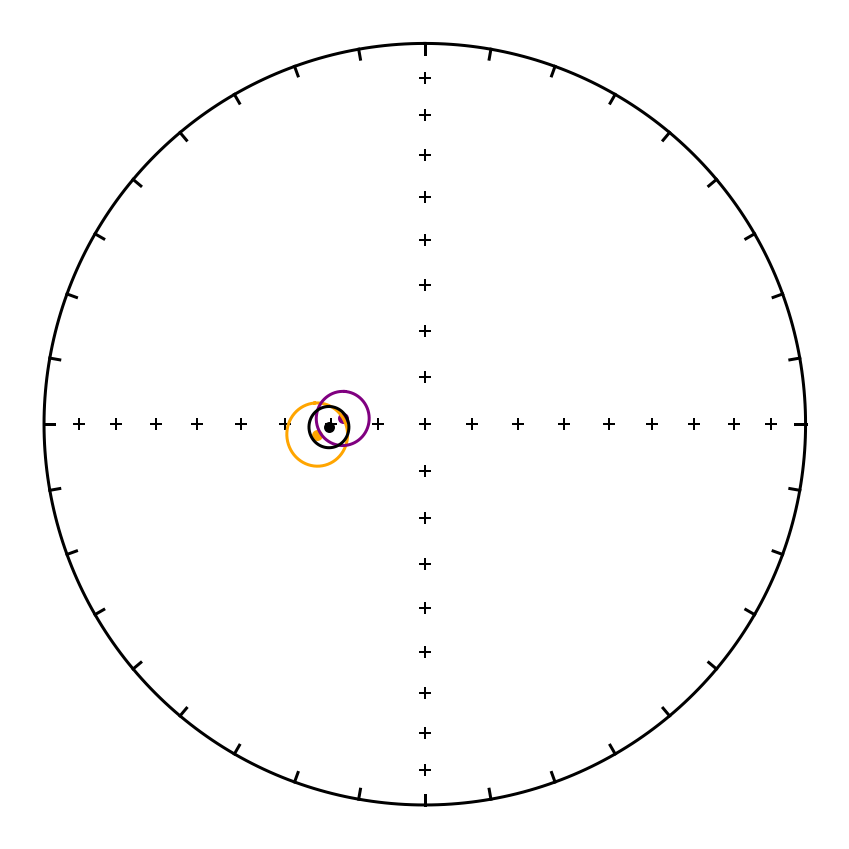

In [60]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CBS1_site_data_ht_tc.dir_dec.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_inc.tolist()[0], 
                   CBS1_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')
ipmag.plot_di_mean(CB11_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB11_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB11_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB11_CSB1_mean_dir['dec'], 
                   CB11_CSB1_mean_dir['inc'],
                   CB11_CSB1_mean_dir['alpha95'], color='k', label='combined mean')

#### CB12

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [61]:
CB12_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB12']
CB12_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB12']
CB12_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB12']

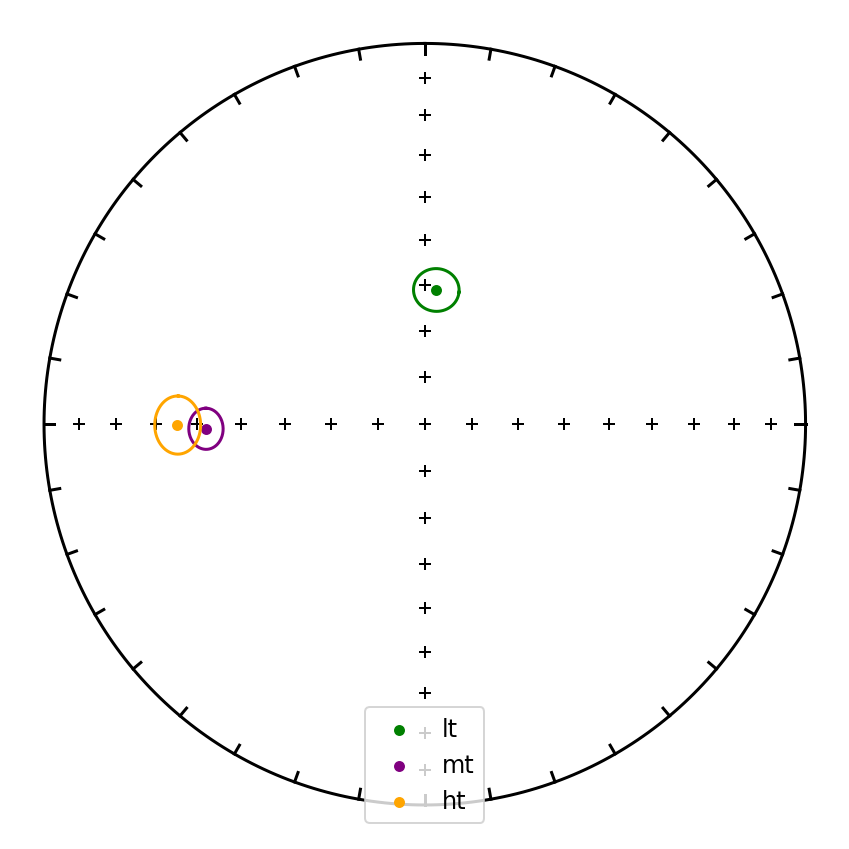

In [62]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB12_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB12_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB12_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB12_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB12_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB12_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB12_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB12_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB12_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB13

This flow has a lt pdf component and a characteristic mt component after removal of the lt component. It has minimal ht component. The mt component has quite a shallow inclination.

In [63]:
CB13_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB13']
CB13_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB13']

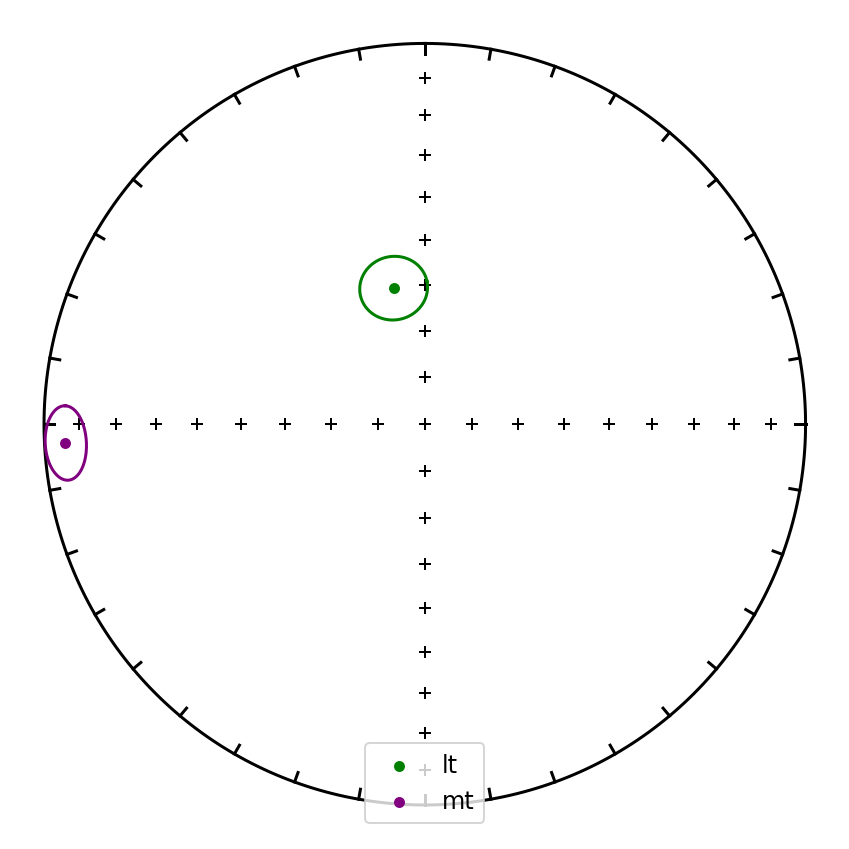

In [64]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB13_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB13_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB13_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB13_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB13_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB13_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB14

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [65]:
CB14_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB14']
CB14_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB14']
CB14_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB14']

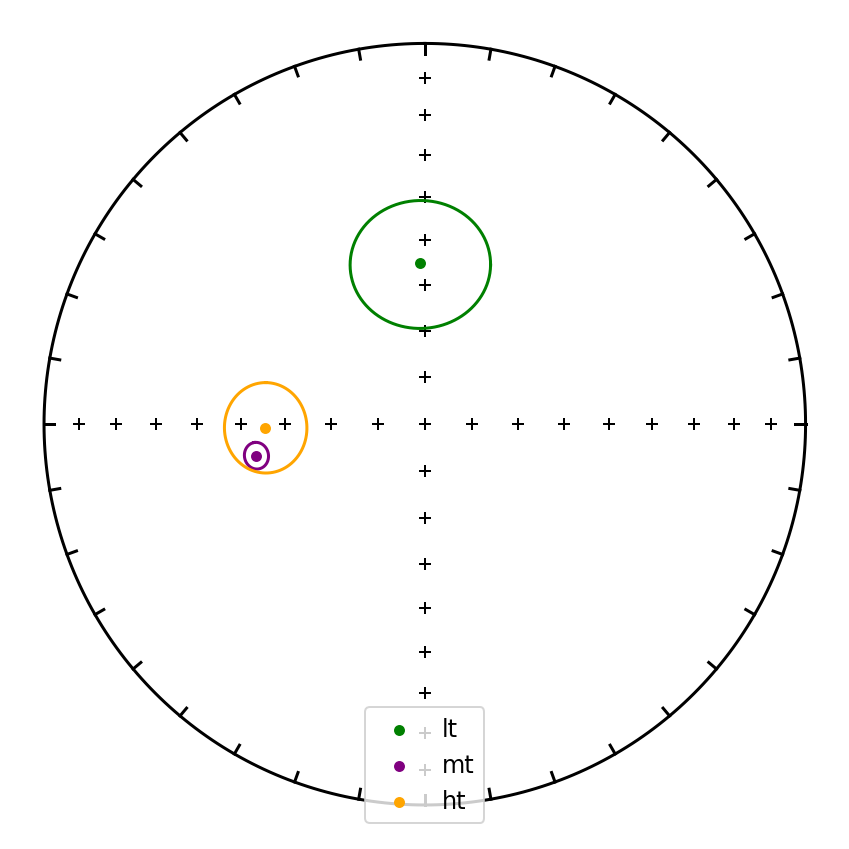

In [66]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB14_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB14_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB14_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB14_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB14_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB14_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB14_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB14_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB14_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB15

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [67]:
CB15_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB15']
CB15_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB15']
CB15_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB15']

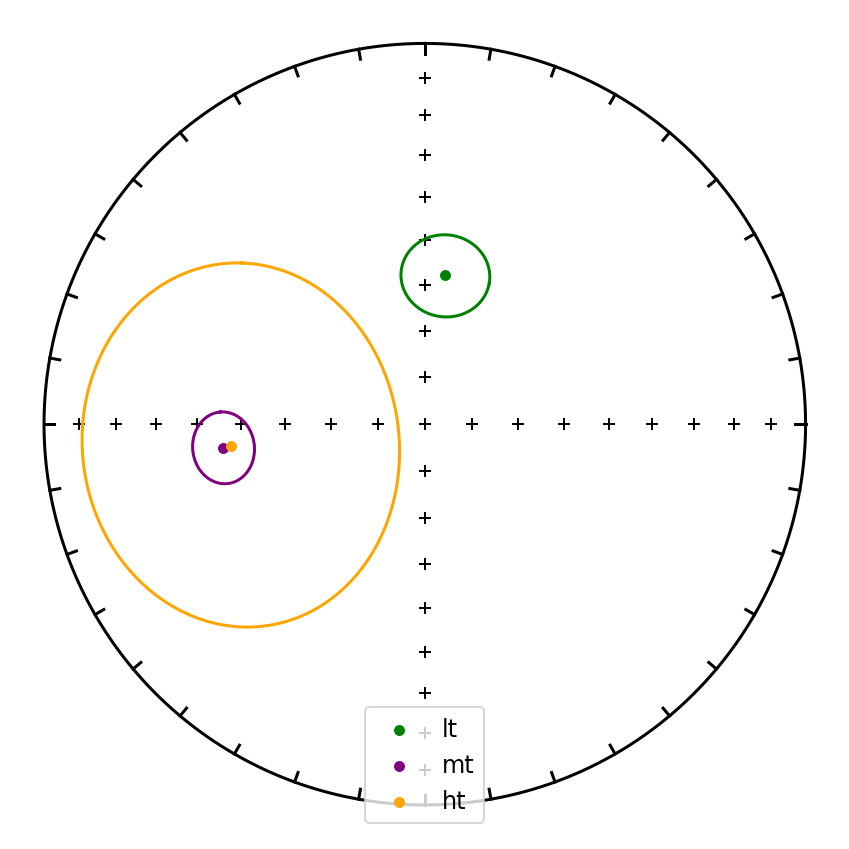

In [68]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB15_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB15_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB15_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB15_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB15_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB15_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB15_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB15_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB15_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB16

This flow has a lt pdf component and a characteristic mt component after removal of the lt component. It has minimal ht component.

In [69]:
CB16_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB16']
CB16_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB16']

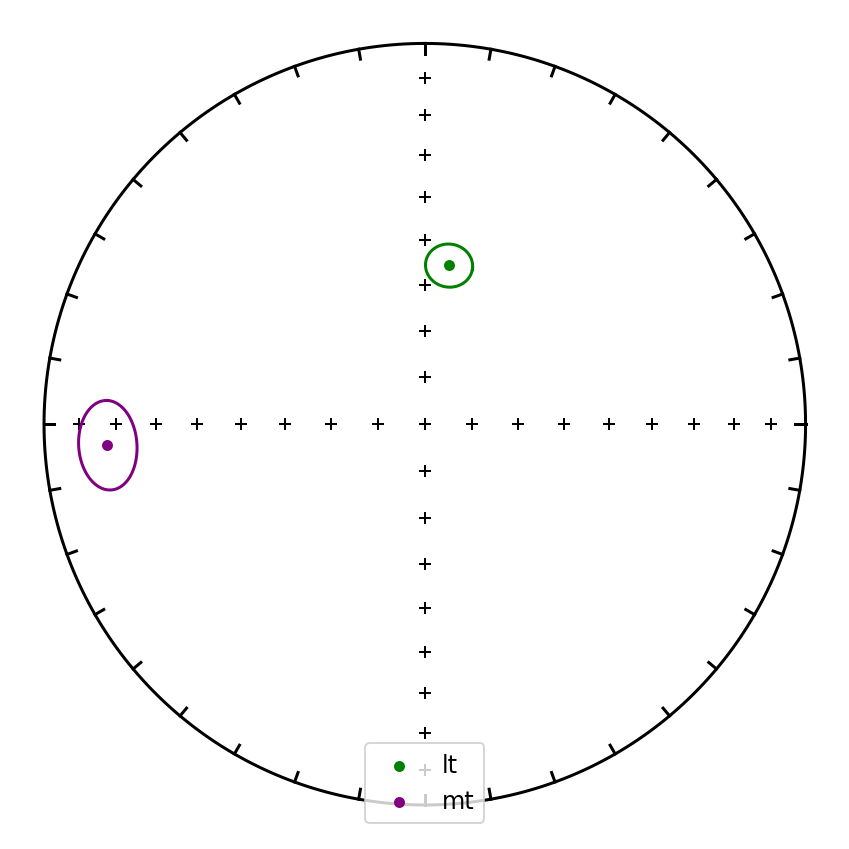

In [70]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB16_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB16_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB16_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB16_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB16_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB16_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB17

This flow has a lt pdf component and a characteristic mt component after removal of the lt component. It has minimal ht component.

In [71]:
CB17_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB17']
CB17_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB17']

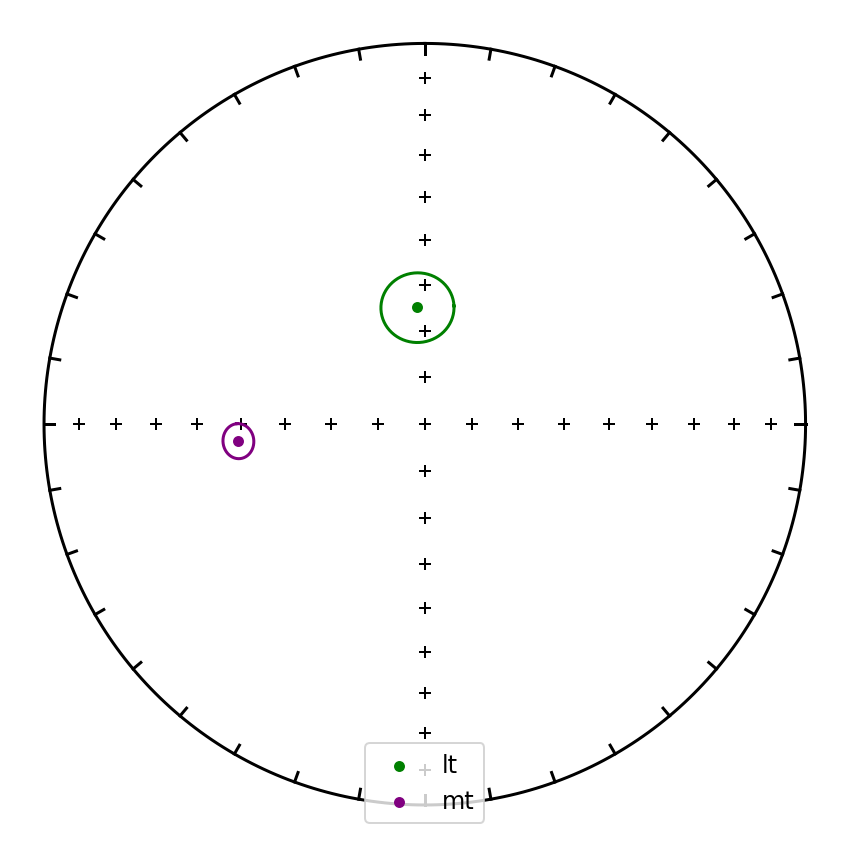

In [72]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB17_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB17_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB17_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB17_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB17_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB17_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB18

This flow has a lt pdf component and similar mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [73]:
CB18_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB18']
CB18_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB18']
CB18_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB18']

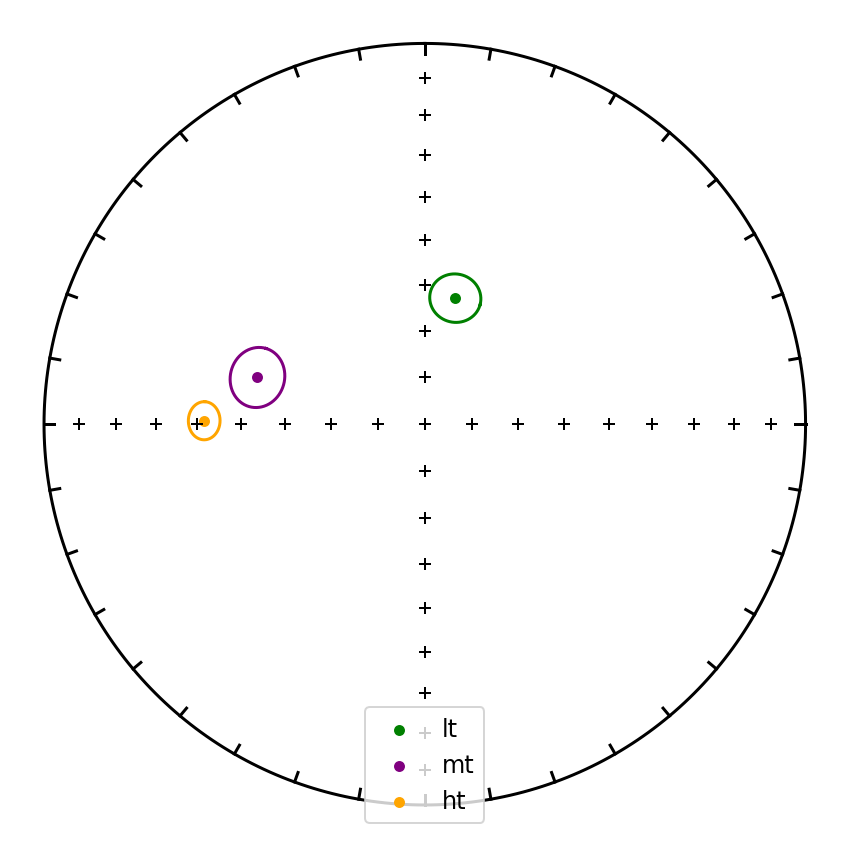

In [74]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB18_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB18_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB18_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB18_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB18_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB18_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB18_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB18_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB18_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### Basalt Canyon summary

combining CB8-CB18 and CBS1 site data

In [75]:
CB_Basalt_Canyon_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'].isin(['CB8','CB9', 'CB10', 'CB12', 'CB13', 'CB14', 'CB15', 'CB16', 'CB17', 'CB18'])] 

In [76]:
CB_Basalt_Canyon_tc = CB_Basalt_Canyon_tc.append({ 'site': 'CB11-CBS1',
                            'location':                                                       'Grand Canyon',
                            'samples':             'CB11-2:CB11-4:CB11-5:CB11-6:CB11-2-7:CB11-8:CBS1-1:CBS1-2:CBS1-3:CBS1-4:CBS1-5:CBS1-6:CBS1-7:CBS1-8',
                            'specimens':           'CB11-2a:CB11-4a:CB11-5a:CB11-6a:CB11-2-7a:CB11-8a:CBS1-1a:CBS1-2a:CBS1-3a:CBS1-4a:CBS1-5a:CBS1-6a:CBS1-7a:CBS1-8a',
                            'dir_alpha95':                                   round(CB11_CSB1_mean_dir['alpha95'],1),
                            'dir_comp_name':                                                            'mt',
                            'dir_dec':                                                              round(CB11_CSB1_mean_dir['dec'],1),
                            'dir_inc':                                                              round(CB11_CSB1_mean_dir['inc'],1),
                            'dir_k':                                                                round(CB11_CSB1_mean_dir['k'],1),
                            'dir_n_samples':                                                        13,
                            'dir_n_specimens':                                                      13,
                            'dir_n_specimens_lines':                                                13,
                            'dir_n_specimens_planes':                                               0,
                            'dir_polarity':                                                              't',
                            'dir_r':                                                                round(CB11_CSB1_mean_dir['r'],1),
                            'dir_tilt_correction':                                                     100,
                            'lat':                                                                   CB11_CBS1['lat'].tolist()[0],
                            'lon':                                                                   CB11_CBS1['lon'].tolist()[0],
                            'analysts':                                                                'NaN',
                            'criteria':                                                             'ACCEPT',
                            'software_packages':                          'pmagpy-4.2.24-1: demag_gui.v.3.0',
                            'citations':                                                        'This study',
                            'method_codes':              'LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO',
                            'result_quality':                                                            'g',
                            'vgp_dm':                                                                  CB11_CSB1_dpdm[2],
                            'vgp_dp':                                                                  CB11_CSB1_dpdm[3],
                            'vgp_lat':                                                                CB11_CSB1_mean_pole['inc'],
                            'vgp_lon':                                                                CB11_CSB1_mean_pole['dec']}, ignore_index=1)


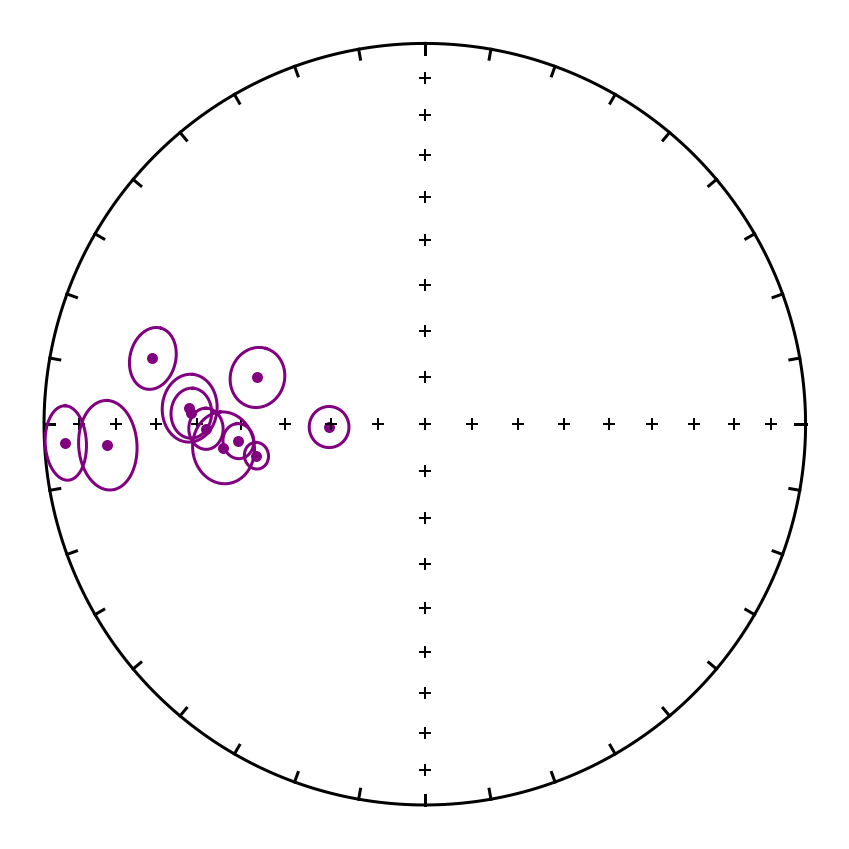

In [77]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Basalt_Canyon_tc.shape[0]):
    ipmag.plot_di_mean(CB_Basalt_Canyon_tc['dir_dec'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_inc'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')
# plt.legend()
plt.show()

### Cardenas Basalt summary

In [98]:
Cardenas_Basalt_all = pd.concat([CB_Nankoweap_tc,CB_Lava_Chuar_mt_tc, CB_Basalt_Canyon_tc])
Cardenas_Basalt_all_mean_pole = ipmag.fisher_mean(Cardenas_Basalt_all.vgp_lon.tolist(), Cardenas_Basalt_all.vgp_lat.tolist())
Cardenas_Basalt_all_mean_pole

{'dec': 183.92013652971943,
 'inc': 15.934944694473888,
 'n': 18,
 'r': 17.25133015447107,
 'k': 22.70693831403029,
 'alpha95': 7.415071700086885,
 'csd': 16.99830935627096}

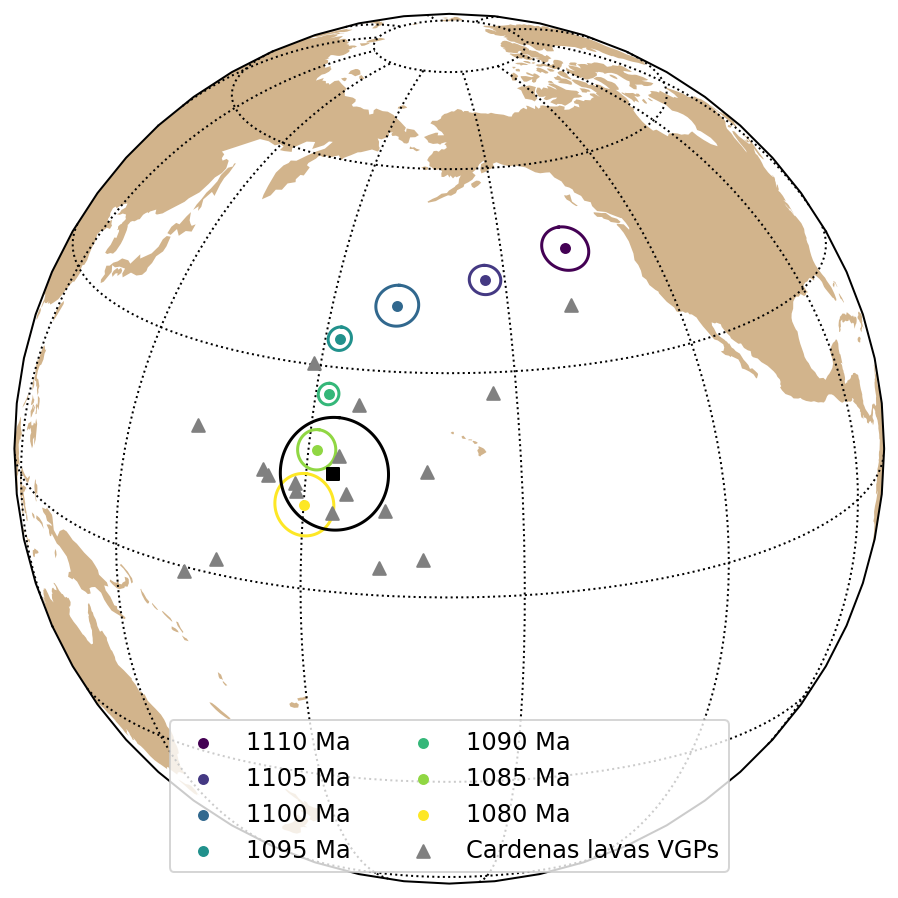

In [ ]:
m = plot_APWP()

ipmag.plot_vgp(m, Cardenas_Basalt_all['vgp_lon'].tolist(), 
               Cardenas_Basalt_all['vgp_lat'].tolist(), 
               marker='^', markersize=40, edge=None, 
               color = 'gray', label='Cardenas lavas VGPs')
ipmag.plot_pole(m, Cardenas_Basalt_all_mean_pole['dec'], Cardenas_Basalt_all_mean_pole['inc'], Cardenas_Basalt_all_mean_pole['alpha95'], marker='s', markersize=40)
plt.legend(loc=8, ncol=2, fontsize=12)
plt.show()

{'Mode': 'Mode 1',
 'Dec': 183.66683370231632,
 'Inc': 15.677956138450728,
 'N': 18,
 'Mu': 1.1751129155852367,
 'Mu_critical': 1.207,
 'Me': 0.6415153139630227,
 'Me_critical': 1.094,
 'Test_result': 'Consistent with Fisher distribution'}

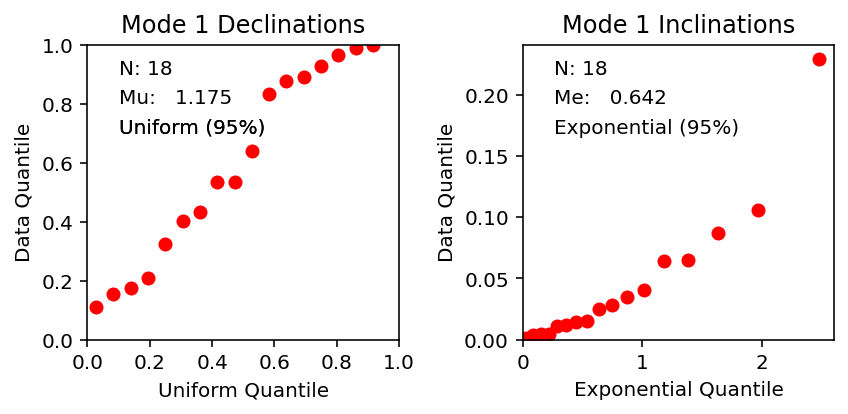

In [99]:
ipmag.fishqq(lon=Cardenas_Basalt_all['vgp_lon'].tolist(), lat=Cardenas_Basalt_all['vgp_lat'].tolist())

### Cardenas Basalt + UI1, UI2, UI3 site mean directions

In [80]:
CB_tc = pd.concat([CB_Nankoweap_tc,CB_Lava_Chuar_mt_tc,CB_Basalt_Canyon_tc])
# CB_tc

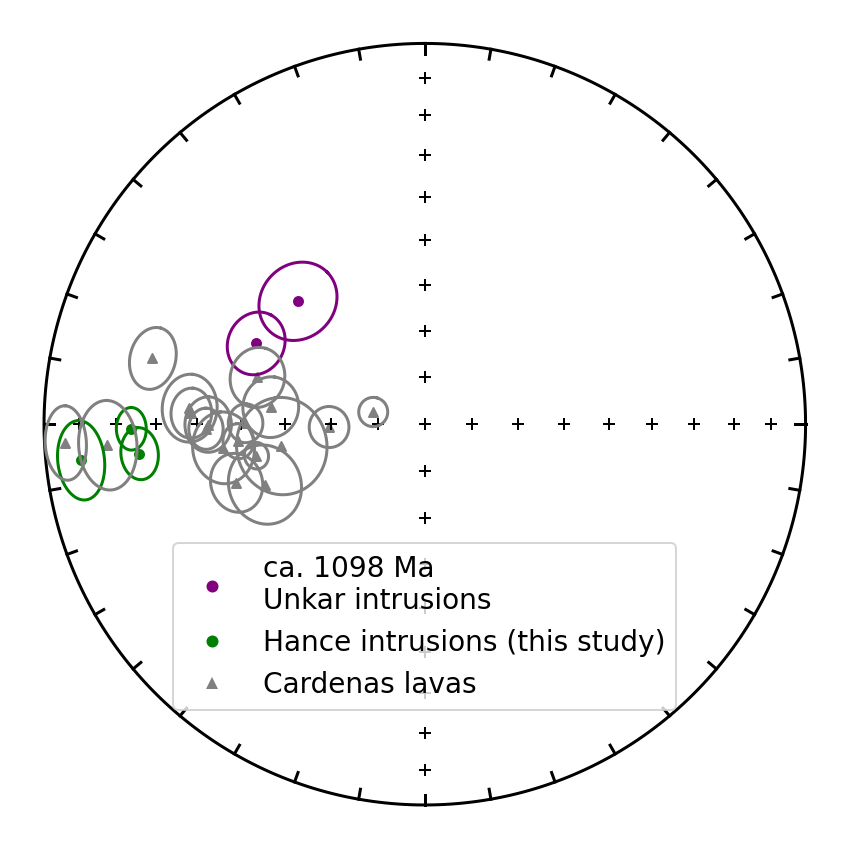

In [81]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

for i in range(UI_1083_site_data_tc.shape[0]):
    ipmag.plot_di_mean(UI_1083_site_data_tc['dir_dec'].tolist()[i], 
                     UI_1083_site_data_tc['dir_inc'].tolist()[i], 
                     UI_1083_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'g')

for i in range(UI_1098_site_data_tc.shape[0]):
    ipmag.plot_di_mean(UI_1098_site_data_tc['dir_dec'].tolist()[i], 
                     UI_1098_site_data_tc['dir_inc'].tolist()[i], 
                     UI_1098_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')
    
for i in range(CB_Nankoweap_tc.shape[0]):
    ipmag.plot_di_mean(CB_Nankoweap_tc['dir_dec'].tolist()[i], 
                     CB_Nankoweap_tc['dir_inc'].tolist()[i], 
                     CB_Nankoweap_tc['dir_alpha95'].tolist()[i],
                     color = 'gray', marker='^')
    
for i in range(CB_Lava_Chuar_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_Lava_Chuar_mt_tc['dir_dec'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_inc'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'gray', marker='^')
    
for i in range(CB_Basalt_Canyon_tc.shape[0]):
    ipmag.plot_di_mean(CB_Basalt_Canyon_tc['dir_dec'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_inc'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_alpha95'].tolist()[i],
                     color = 'gray', marker='^')


legend_elements = [Line2D([0], [0], color='None',  marker='o', markerfacecolor='purple', label='ca. 1098 Ma\nUnkar intrusions',markeredgecolor='None'),
                   Line2D([0], [0], color='None', marker='o', markerfacecolor='green', label='Hance intrusions (this study)',markeredgecolor='None'),
                   Line2D([0], [0], color='None', marker='^', markerfacecolor='gray', label='Cardenas lavas',markeredgecolor='None')]

# Create the figure

plt.legend(bbox_to_anchor=(0.5, 0.135), fontsize=14, handles=legend_elements)
plt.savefig('code_output/Cardenas_Unkar_directions.pdf', bbox_inches='tight')
plt.show()

## Import data from Weil et al., 2003

- Weil et la. ,2003: Paleomagnetism of Middle Proterozoic mafic intrusions and Upper Proterozoic (Nankoweap) red beds from the Lower Grand Canyon Supergroup, Arizona

That study also sampled Cardenas Basalt and Unkar intrusions.

All Cardenas Basalt sites in that study were collected within Basalt Canyon. We collected a total of 11 sites following the stratigraphy in Basalt Canyon and thus our sites likely overlaps with theirs. We can compare the site mean directions of their J2, Card20, Card22 with our Basalt Canyon directions.

In [82]:
Weil2003_data = pd.read_csv('../data/pmag_compiled/Weil2003a_sites.txt', header=1, sep='\t')

Weil2003_data['dec_tc'] = [pmag.dotilt(Weil2003_data['dir_dec'][i], 
                                        Weil2003_data['dir_inc'][i], 
                                        Weil2003_data['bedding strike'][i]+90,  
                                        Weil2003_data['bedding dip'][i])[0] for i in range(Weil2003_data.shape[0])]
Weil2003_data['inc_tc'] = [pmag.dotilt(Weil2003_data['dir_dec'][i], 
                                        Weil2003_data['dir_inc'][i], 
                                        Weil2003_data['bedding strike'][i]+90,  
                                        Weil2003_data['bedding dip'][i])[1] for i in range(Weil2003_data.shape[0])]
Weil2003_data = ipmag.vgp_calc(Weil2003_data, 
                               tilt_correction='yes',
                                site_lon='lon',
                                site_lat='lat',
                                dec_tc='dec_tc',
                                inc_tc='inc_tc',)
Weil2003_data = Weil2003_data[Weil2003_data['dir_alpha95']<=15]
Weil2003_Basalt_Canyon = Weil2003_data[Weil2003_data['site'].isin(['J2', 'Card20', 'Card22'])]
Weil2003_Tanner = Weil2003_data[Weil2003_data['site'].isin(['aw12', 'aw13', 'aw14', 'aw16'])]
Weil2003_Lizard = Weil2003_data[Weil2003_data['site'].isin(['aw24', 'aw26', 'aw27', 'aw29'])]
Weil2003_Birdfoot = Weil2003_data[Weil2003_data['site'].isin(['J4', 'J5'])]
Weil2003_Hance = Weil2003_data[Weil2003_data['site'].isin(['aw30', 'aw31', 'aw32'])]

### compare site directions between Card20-22, and J2 with CB8-CB18b

The site mean directions look similar. We will not include the Weil data in Cardenas mean calculation to avoid repeat sampling of flows.

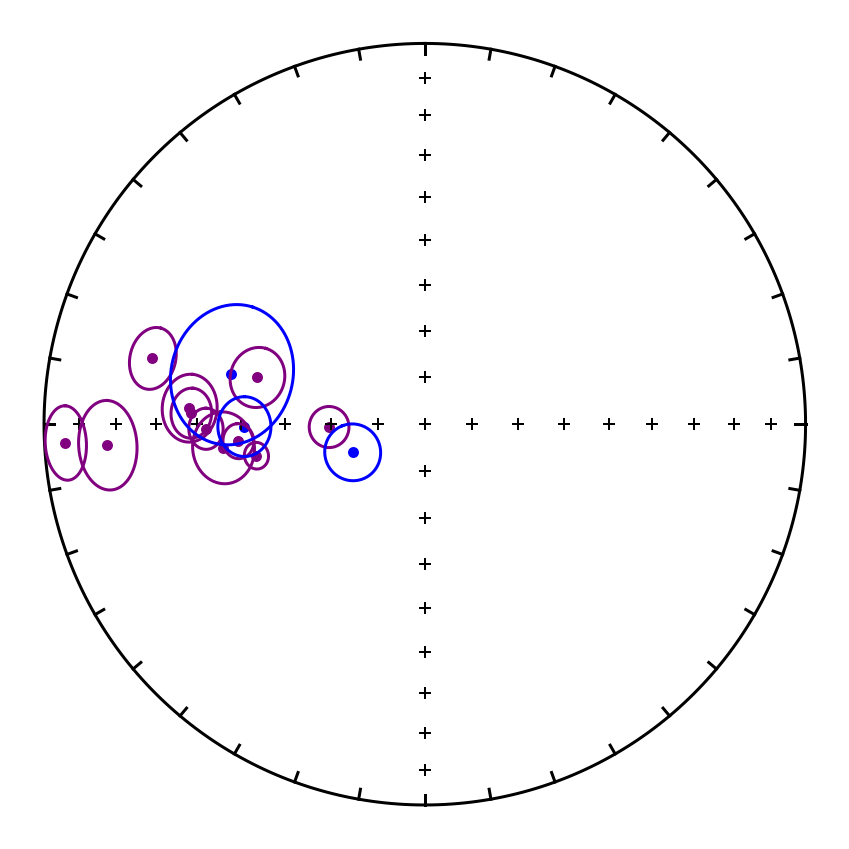

In [83]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Basalt_Canyon_tc.shape[0]):
    ipmag.plot_di_mean(CB_Basalt_Canyon_tc['dir_dec'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_inc'].tolist()[i], 
                     CB_Basalt_Canyon_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

for i in range(Weil2003_Basalt_Canyon.shape[0]):
    ipmag.plot_di_mean(Weil2003_Basalt_Canyon['dec_tc'].tolist()[i], 
                     Weil2003_Basalt_Canyon['inc_tc'].tolist()[i], 
                     Weil2003_Basalt_Canyon['dir_alpha95'].tolist()[i],
                     color = 'blue')

# plt.legend()
plt.show()

### Tanner dikes

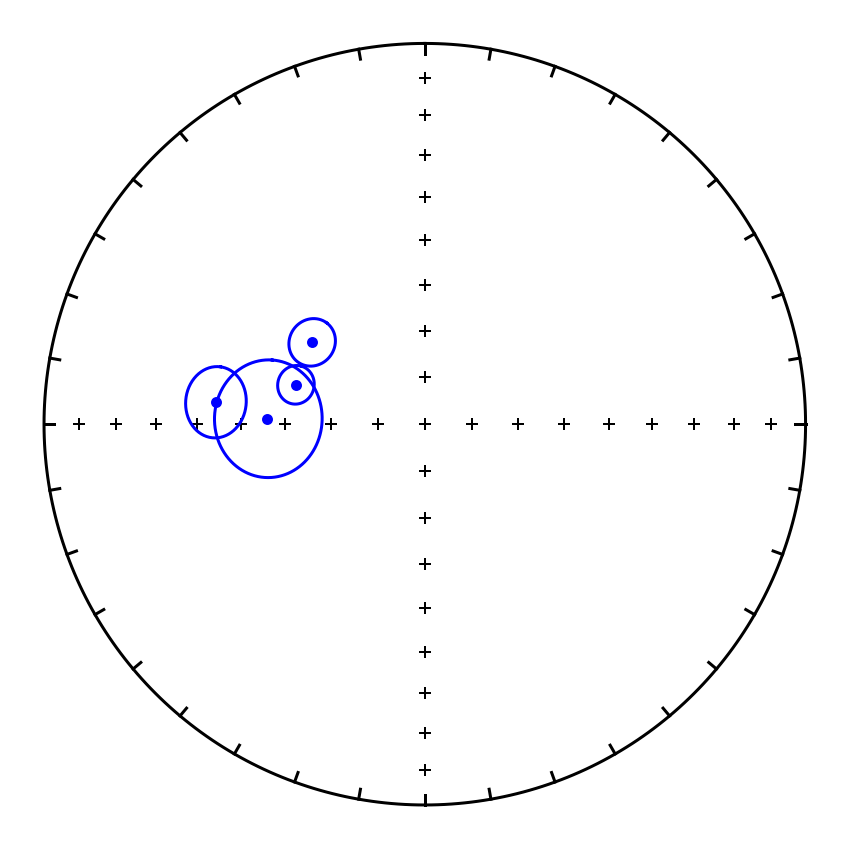

In [84]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(Weil2003_Tanner.shape[0]):
    ipmag.plot_di_mean(Weil2003_Tanner['dir_dec'].tolist()[i], 
                     Weil2003_Tanner['dir_inc'].tolist()[i], 
                     Weil2003_Tanner['dir_alpha95'].tolist()[i],
                     color = 'b')


# plt.legend()
plt.show()

### Lizard dikes

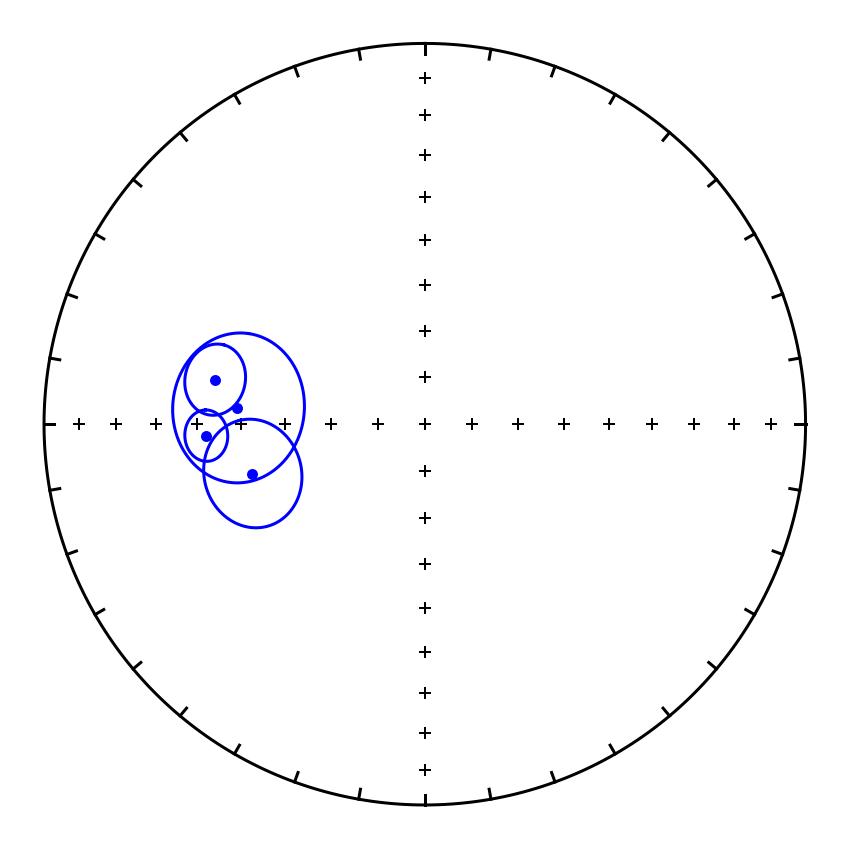

In [85]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(Weil2003_Lizard.shape[0]):
    ipmag.plot_di_mean(Weil2003_Lizard['dir_dec'].tolist()[i], 
                     Weil2003_Lizard['dir_inc'].tolist()[i], 
                     Weil2003_Lizard['dir_alpha95'].tolist()[i],
                     color = 'b')


# plt.legend()
plt.show()

### Birdfoot dikes

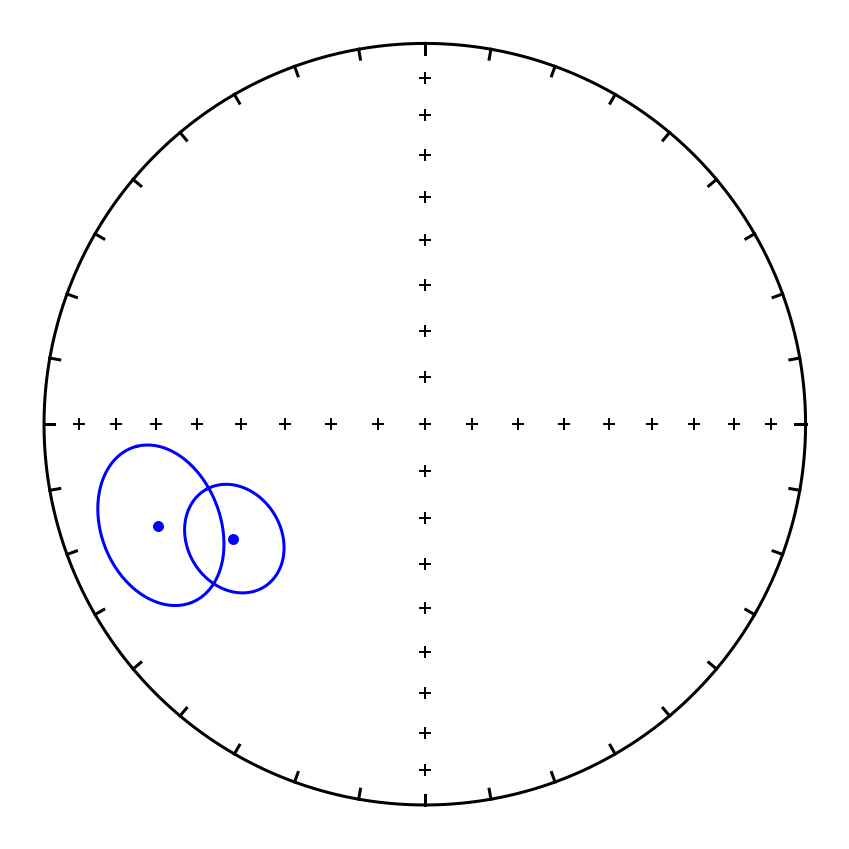

In [86]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(Weil2003_Birdfoot.shape[0]):
    ipmag.plot_di_mean(Weil2003_Birdfoot['dir_dec'].tolist()[i], 
                     Weil2003_Birdfoot['dir_inc'].tolist()[i], 
                     Weil2003_Birdfoot['dir_alpha95'].tolist()[i],
                     color = 'b')


# plt.legend()
plt.show()

### Hance dikes

The directions from Hance dikes are different than what we got... the site locations are slightly different.

I am intended to filter away the large a95 (20º) site and combine the rest Hance directions together.

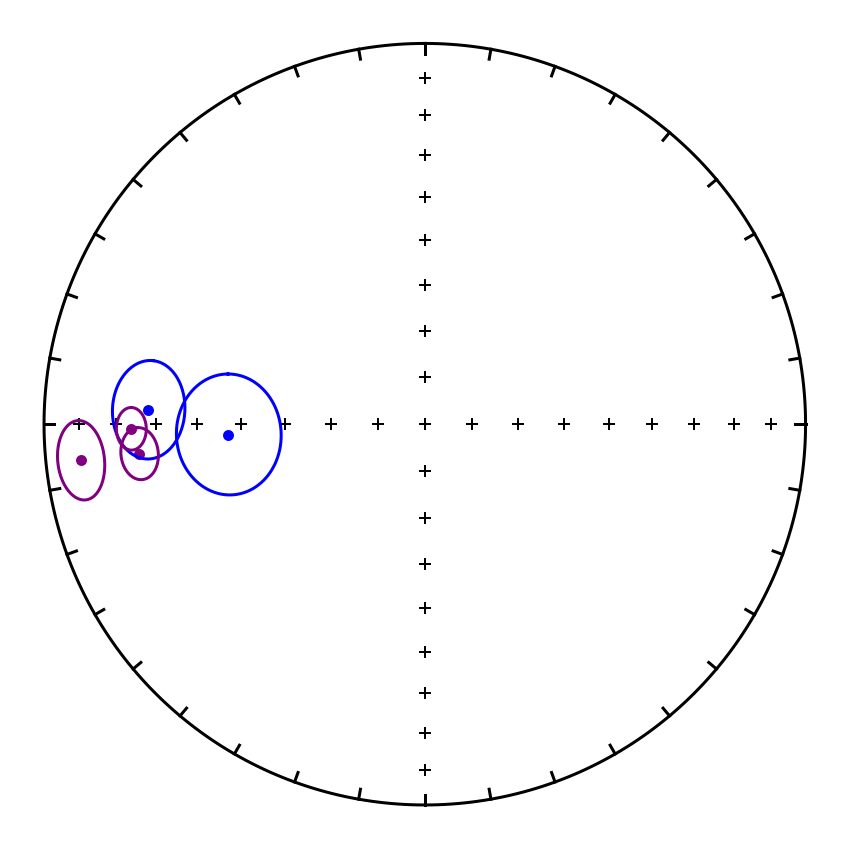

In [87]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(Weil2003_Hance.shape[0]):
    ipmag.plot_di_mean(Weil2003_Hance['dir_dec'].tolist()[i], 
                     Weil2003_Hance['dir_inc'].tolist()[i], 
                     Weil2003_Hance['dir_alpha95'].tolist()[i],
                     color = 'b')
    
for i in range(UI_1083_site_data_tc.shape[0]):
    ipmag.plot_di_mean(UI_1083_site_data_tc['dir_dec'].tolist()[i], 
                     UI_1083_site_data_tc['dir_inc'].tolist()[i], 
                     UI_1083_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

# plt.legend()
plt.show()

Our Hance VGPS vs. Weil Hance VGPs

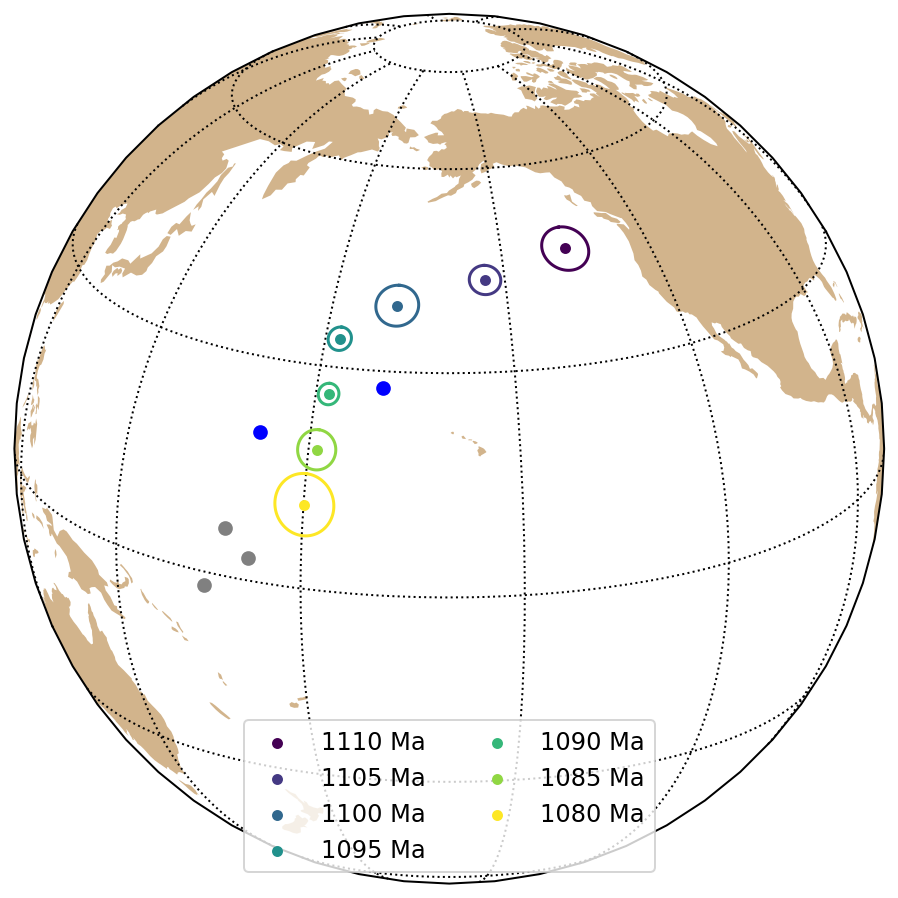

In [88]:
m = plot_APWP()

ipmag.plot_vgp(m, Weil2003_Hance['vgp_lon'].tolist(), Weil2003_Hance['vgp_lat'].tolist(), markersize=40, edge=None, color = 'b')
ipmag.plot_vgp(m, UI_1083_site_data_tc['vgp_lon'].tolist(), UI_1083_site_data_tc['vgp_lat'].tolist(), markersize=40, edge=None, color = 'gray')

plt.legend(loc=8, ncol=2, fontsize=12)
plt.show()

compare out Hance VGPs with intrusion VGPs in the region

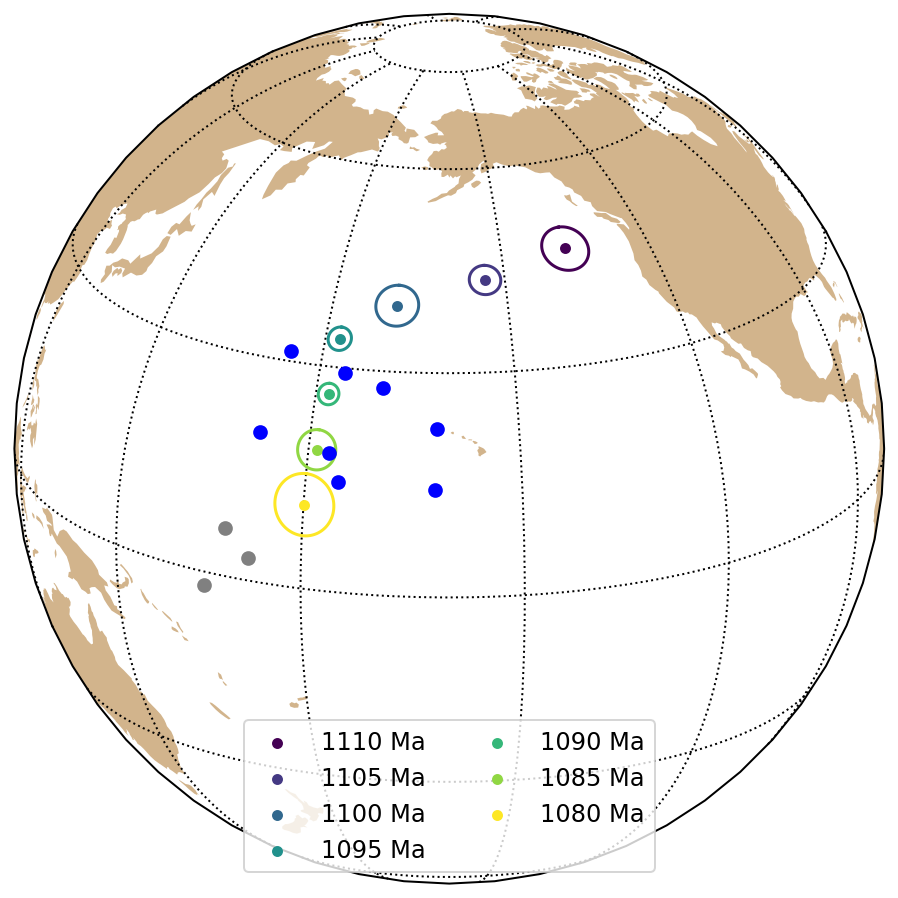

In [89]:
m = plot_APWP()

ipmag.plot_vgp(m, UI_1083_site_data_tc['vgp_lon'].tolist(), UI_1083_site_data_tc['vgp_lat'].tolist(), markersize=40, edge=None, color = 'gray')
# ipmag.plot_vgp(m, Weil2003_Tanner['vgp_lon'].tolist(), Weil2003_Tanner['vgp_lat'].tolist(), markersize=40, edge=None, color = 'b')
ipmag.plot_vgp(m, Weil2003_Birdfoot['vgp_lon'].tolist(), Weil2003_Birdfoot['vgp_lat'].tolist(), markersize=40, edge=None, color = 'b')
ipmag.plot_vgp(m, Weil2003_Lizard['vgp_lon'].tolist(), Weil2003_Lizard['vgp_lat'].tolist(), markersize=40, edge=None, color = 'b')
ipmag.plot_vgp(m, Weil2003_Hance['vgp_lon'].tolist(), Weil2003_Hance['vgp_lat'].tolist(), markersize=40, edge=None, color = 'b')

plt.legend(loc=8, ncol=2, fontsize=12)
plt.show()

In [96]:
Cardenas_intrusions_all_mean_pole = ipmag.fisher_mean(UI_1083_site_data_tc['vgp_lon'].tolist()+
                                                        Weil2003_Tanner['vgp_lon'].tolist()+
                                                        Weil2003_Birdfoot['vgp_lon'].tolist()+
                                                        Weil2003_Lizard['vgp_lon'].tolist()+
                                                        Weil2003_Hance['vgp_lon'].tolist(), 
                                                        UI_1083_site_data_tc['vgp_lat'].tolist()+
                                                        Weil2003_Tanner['vgp_lat'].tolist()+
                                                        Weil2003_Birdfoot['vgp_lat'].tolist()+
                                                        Weil2003_Lizard['vgp_lat'].tolist()+
                                                        Weil2003_Hance['vgp_lat'].tolist())

### interpreted Cardenas intrusions summary

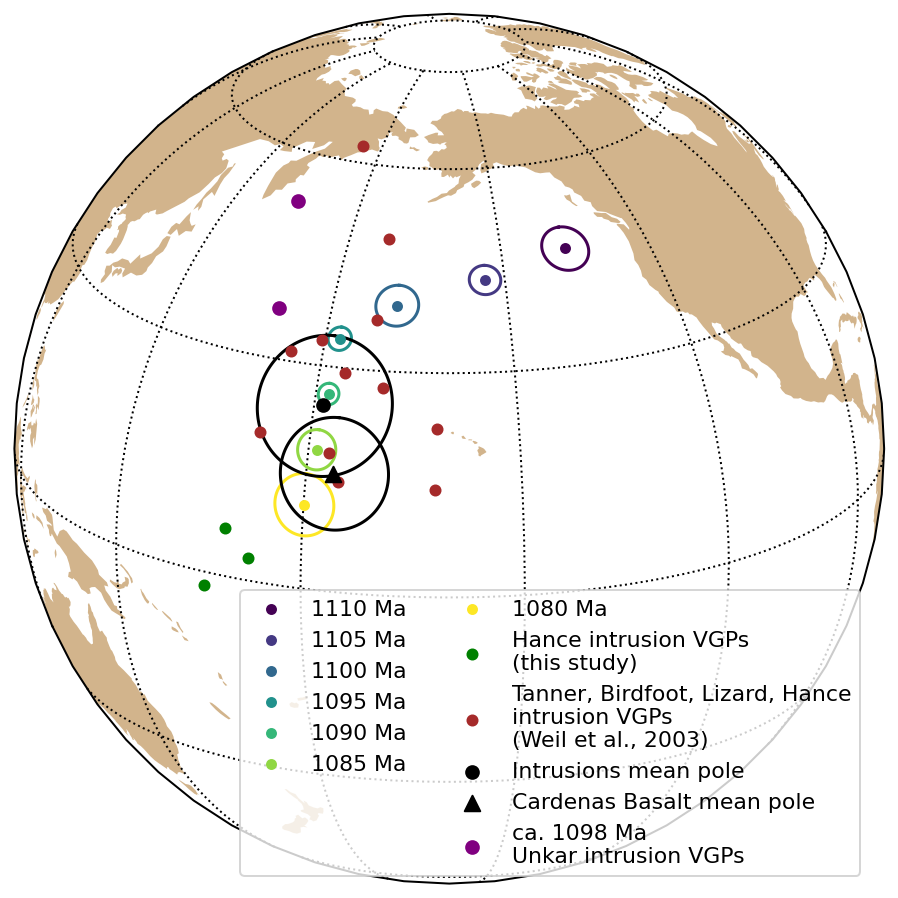

In [97]:
m = plot_APWP()

ipmag.plot_vgp(m, UI_1083_site_data_tc['vgp_lon'].tolist(), UI_1083_site_data_tc['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'green', label='Hance intrusion VGPs\n(this study)')
ipmag.plot_vgp(m, Weil2003_Tanner['vgp_lon'].tolist(), Weil2003_Tanner['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'brown', label='Tanner, Birdfoot, Lizard, Hance\nintrusion VGPs\n(Weil et al., 2003)')
ipmag.plot_vgp(m, Weil2003_Birdfoot['vgp_lon'].tolist(), Weil2003_Birdfoot['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'brown')
ipmag.plot_vgp(m, Weil2003_Lizard['vgp_lon'].tolist(), Weil2003_Lizard['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'brown')
ipmag.plot_vgp(m, Weil2003_Hance['vgp_lon'].tolist(), Weil2003_Hance['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'brown')


ipmag.plot_pole(m, Cardenas_intrusions_all_mean_pole['dec'], 
                Cardenas_intrusions_all_mean_pole['inc'], 
                Cardenas_intrusions_all_mean_pole['alpha95'], 
                marker='o', color='k', edgecolor=None, markersize=40, label='Intrusions mean pole')

# ipmag.plot_vgp(m, Cardenas_Basalt_all['vgp_lon'].tolist(), 
#                Cardenas_Basalt_all['vgp_lat'].tolist(), 
#                marker='^', markersize=60, edge=None, 
#                color = 'gray', label='Cardenas Basalt VGPs', zorder=100)

ipmag.plot_pole(m, Cardenas_Basalt_all_mean_pole['dec'], 
                Cardenas_Basalt_all_mean_pole['inc'], 
                Cardenas_Basalt_all_mean_pole['alpha95'], 
                marker='^', markersize=60, label='Cardenas Basalt mean pole')

ipmag.plot_vgp(m, UI_1098_site_data_tc['vgp_lon'].tolist(), UI_1098_site_data_tc['vgp_lat'].tolist(), 
               markersize=40, edge=None, color = 'purple', label='ca. 1098 Ma\nUnkar intrusion VGPs')

plt.legend(bbox_to_anchor=(0.985, 0.35), ncol=2, fontsize=11)
plt.savefig('code_output/Intrusion_extrusion_pole.pdf', bbox_inches='tight')
plt.show()

In [ ]:
Kewee_track_poles = pd.read_csv('../data/pmag_compiled/keweenawan_pole_means.csv')
MI_pole = Kewee_track_poles[Kewee_track_poles['Polarity'] == 'MI'].reset_index(drop=1)
Nonesuch_pole = Kewee_track_poles[Kewee_track_poles['Polarity'] == 'Nonesuch'].reset_index(drop=1)
Freda_pole = Kewee_track_poles[Kewee_track_poles['Polarity'] == 'Freda'].reset_index(drop=1)

Nonesuch_Kent_stats = {'dec': 182.91788096243135,
                        'inc': 6.613852473782791,
                        'n': 100000,
                        'Zdec': 280.1822018286548,
                        'Zinc': 47.479879738402786,
                        'Edec': 86.97649522123652,
                        'Einc': 41.7562140964714,
                        'Zeta': 2.7717009260772785,
                        'Eta': 2.0259662318845577,
                        'R1': 0.9997006454105211,
                        'R2': 0.00018157508466288416}


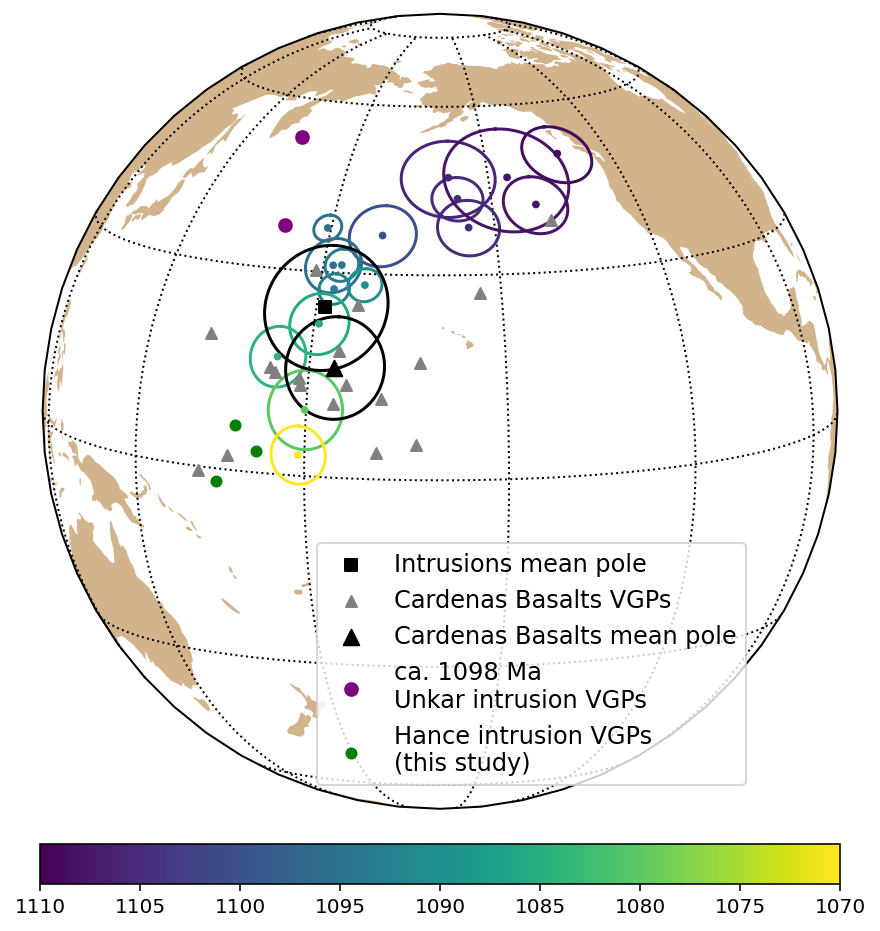

In [ ]:
m = ipmag.make_orthographic_map(central_latitude=10,central_longitude=200, land_edge_color='none', grid_lines=True,
    lat_grid=[-80.0, -60.0, -30.0, 0.0, 30.0, 60.0, 80.0],
    lon_grid=[-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0])

plt.figure(num=1,figsize=(10, 10))

vmin=1070
vmax=1110
cNorm = colors.Normalize(vmin, vmax)
Keween_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for n in range(Kewee_track_poles.shape[0]):
    rgba = Keween_scalarMap.to_rgba(Kewee_track_poles['AgeNominal'][n])
    hex_color = colors.rgb2hex(rgba)
#     print(hex_color)
    ipmag.plot_pole(m,Kewee_track_poles['PLon'][n],Kewee_track_poles['PLat'][n],Kewee_track_poles['A95'][n],
                    color=hex_color, markersize=15, edgecolor='none')

cbar=plt.colorbar(Keween_scalarMap,orientation='horizontal',fraction=0.046, pad=0.04)
cbar.ax.invert_xaxis()

ipmag.plot_pole(m, Cardenas_intrusions_all_mean_pole['dec'], 
                Cardenas_intrusions_all_mean_pole['inc'], 
                Cardenas_intrusions_all_mean_pole['alpha95'], 
                marker='s', color='k', edgecolor=None, markersize=40, label='Intrusions mean pole')

ipmag.plot_vgp(m, Cardenas_Basalt_all['vgp_lon'].tolist(), 
               Cardenas_Basalt_all['vgp_lat'].tolist(), 
               marker='^', markersize=30, edge=None, 
               color = 'gray', label='Cardenas Basalt VGPs', zorder=100)

ipmag.plot_pole(m, Cardenas_Basalt_all_mean_pole['dec'], 
                Cardenas_Basalt_all_mean_pole['inc'], 
                Cardenas_Basalt_all_mean_pole['alpha95'], 
                marker='^', markersize=60, label='Cardenas Basalt mean pole')

ipmag.plot_vgp(m, UI_1098_site_data_tc['vgp_lon'].tolist(), UI_1098_site_data_tc['vgp_lat'].tolist(), 
               markersize=40, edge=None, color = 'purple', label='ca. 1098 Ma\nUnkar intrusion VGPs')
ipmag.plot_vgp(m, UI_1083_site_data_tc['vgp_lon'].tolist(), UI_1083_site_data_tc['vgp_lat'].tolist(), 
               markersize=25, edge=None, color = 'green', label='Hance intrusion VGPs\n(this study)')
                                         
# plt.legend(bbox_to_anchor=(1 ,0.6), ncol=1, fontsize=12)
plt.legend(bbox_to_anchor=(0.9, 0.35), ncol=1, fontsize=12)

# plt.savefig('../Figures/Pmag/Jacobsville_pole_plot.pdf', bbox_inches='tight')
plt.show()

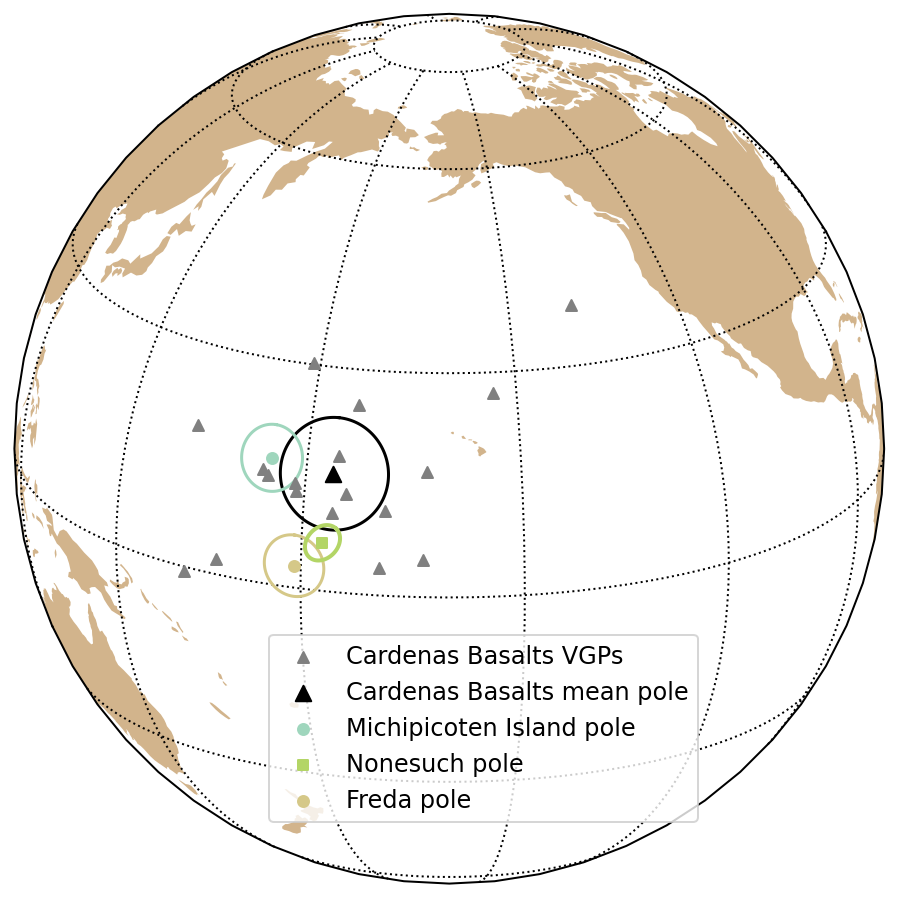

In [ ]:
m = ipmag.make_orthographic_map(central_latitude=20,central_longitude=200, land_edge_color='none', grid_lines=True,
    lat_grid=[-80.0, -60.0, -30.0, 0.0, 30.0, 60.0, 80.0],
    lon_grid=[-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0])

# ipmag.plot_pole(m, Cardenas_intrusions_all_mean_pole['dec'], 
#                 Cardenas_intrusions_all_mean_pole['inc'], 
#                 Cardenas_intrusions_all_mean_pole['alpha95'], 
#                 marker='s', color='k', edgecolor=None, markersize=40, label='Intrusions mean pole')

ipmag.plot_vgp(m, Cardenas_Basalt_all['vgp_lon'].tolist(), 
               Cardenas_Basalt_all['vgp_lat'].tolist(), 
               marker='^', markersize=30, edge=None, 
               color = 'gray', label='Cardenas Basalt VGPs', zorder=100)

ipmag.plot_pole(m, Cardenas_Basalt_all_mean_pole['dec'], 
                Cardenas_Basalt_all_mean_pole['inc'], 
                Cardenas_Basalt_all_mean_pole['alpha95'], 
                marker='^', markersize=60, label='Cardenas Basalt mean pole')

# ipmag.plot_vgp(m, UI_1098_site_data_tc['vgp_lon'].tolist(), UI_1098_site_data_tc['vgp_lat'].tolist(), 
#                markersize=40, edge=None, color = 'purple', label='ca. 1098 Ma\nUnkar intrusion VGPs')
# ipmag.plot_vgp(m, UI_1083_site_data_tc['vgp_lon'].tolist(), UI_1083_site_data_tc['vgp_lat'].tolist(), 
#                markersize=25, edge=None, color = 'green', label='Hance intrusions VGPs\n(this study)')

ipmag.plot_pole(m, MI_pole['PLon'][0], MI_pole['PLat'][0], MI_pole['A95'][0], color=MI_pole['color'][0], edgecolor=None, markersize=30, label='Michipicoten Island pole')
ipmag.plot_pole_ellipse(m, Nonesuch_Kent_stats, color=Nonesuch_pole['color'][0], edgecolor=None, markersize=30, lw=2, label='Nonesuch pole')
ipmag.plot_pole(m, Freda_pole['PLon'][0], Freda_pole['PLat'][0], Freda_pole['A95'][0], color=Freda_pole['color'][0], edgecolor=None, markersize=30, label='Freda pole')

plt.legend(bbox_to_anchor=(0.8, 0.3), ncol=1, fontsize=12)

plt.savefig('./code_output/Cardenas_pole.pdf', bbox_inches='tight')
plt.show()

Let's do a common mean test of these dike poles with those Cardenas Basalt poles

They do pass a common mean test with a classfication of 'C'

In [ ]:
Cardenas_basalt_di_block = ipmag.make_di_block(Cardenas_Basalt_all['vgp_lon'].tolist(), 
                                                 Cardenas_Basalt_all['vgp_lat'].tolist())
Cardenas_intrusions_di_block = ipmag.make_di_block(Cardenas_intrusions_all['vgp_lon'].tolist(), 
                                                 Cardenas_intrusions_all['vgp_lat'].tolist())
ipmag.common_mean_watson(Cardenas_basalt_di_block, Cardenas_intrusions_di_block)

Results of Watson V test: 

Watson's V:           3.9
Critical value of V:  6.4
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 9.2
Critical angle for M&M1990:   11.7
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 9.1809558447595, 11.691686495862651, 'C')

## Applying Bryan 1986 Colorado plateau rotation to Cardenas Basalts poles

3.9 (1.4-6.6 95% confidence interval) CW rotation of the plateau around Euler pole of 37N, 103W

In [94]:
Cardenas_mean_pole_lat_rot, Cardenas_mean_pole_lon_rot = pmag.pt_rot([37, -103, 3.9], Cardenas_Basalt_all['vgp_lat'].tolist(), Cardenas_Basalt_all['vgp_lon'].tolist())
Cardenas_mean_pole_rot = ipmag.fisher_mean(Cardenas_mean_pole_lon_rot, Cardenas_mean_pole_lat_rot)

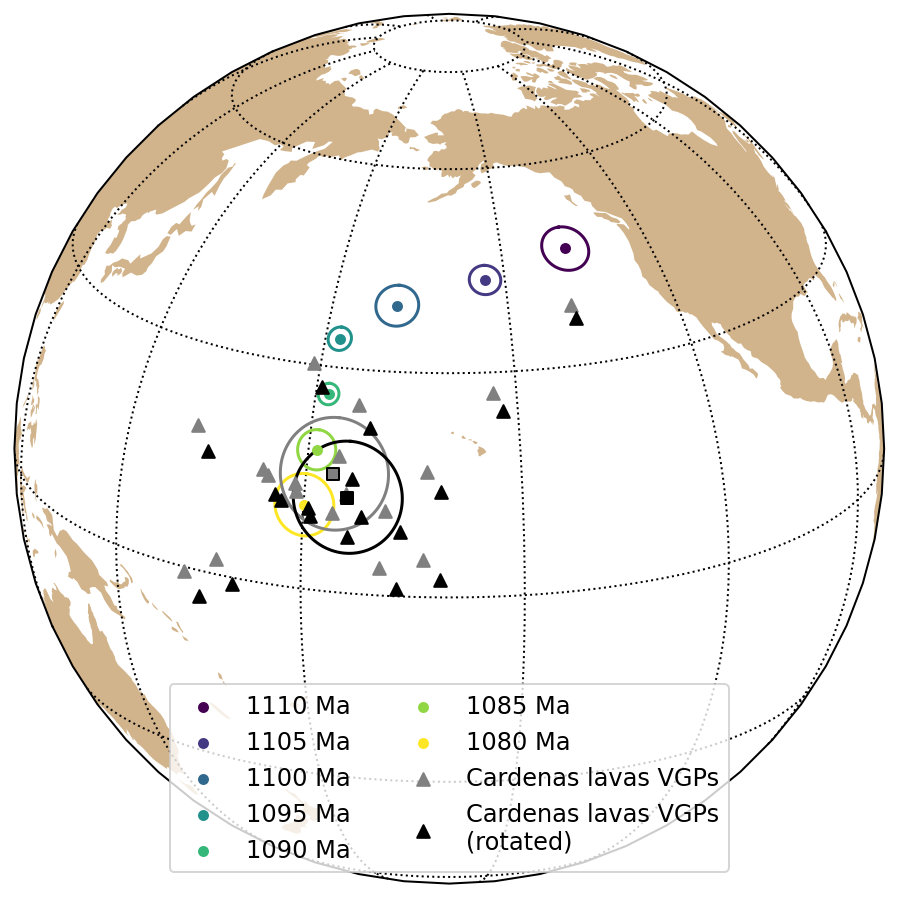

In [95]:
m = plot_APWP()

ipmag.plot_vgp(m, Cardenas_Basalt_all['vgp_lon'].tolist(), 
               Cardenas_Basalt_all['vgp_lat'].tolist(), 
               marker='^', markersize=40, edge=None, 
               color = 'gray', label='Cardenas lavas VGPs')

ipmag.plot_vgp(m, Cardenas_mean_pole_lon_rot,
               Cardenas_mean_pole_lat_rot, 
               marker='^', markersize=40, edge=None, 
               color = 'k', label='Cardenas lavas VGPs\n(rotated)')

ipmag.plot_pole(m, Cardenas_Basalt_all_mean_pole['dec'], Cardenas_Basalt_all_mean_pole['inc'], Cardenas_Basalt_all_mean_pole['alpha95'], marker='s', color='gray', markersize=40)

ipmag.plot_pole(m, Cardenas_mean_pole_rot['dec'], Cardenas_mean_pole_rot['inc'], Cardenas_Basalt_all_mean_pole['alpha95'], marker='s', color='k', markersize=40)

plt.legend(loc=8, ncol=2, fontsize=12)
plt.show()